In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import hashlib
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from collections import Counter

In [141]:
!pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 13.8 MB/s eta 0:00:00 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


# Load Data

In [2]:
df = pd.read_csv('reddit_crawler_20250701.csv')
df.head(10)

subreddit  post_id                         post_title  \
0  Aphantasia  1logpyp  "What color pops up in your mind"   
1  Aphantasia  1logpyp  "What color pops up in your mind"   
2  Aphantasia  1logpyp  "What color pops up in your mind"   
3  Aphantasia  1logpyp  "What color pops up in your mind"   
4  Aphantasia  1logpyp  "What color pops up in your mind"   
5  Aphantasia  1logpyp  "What color pops up in your mind"   
6  Aphantasia  1logpyp  "What color pops up in your mind"   
7  Aphantasia  1logpyp  "What color pops up in your mind"   
8  Aphantasia  1logpyp  "What color pops up in your mind"   
9  Aphantasia  1logpyp  "What color pops up in your mind"   

                                           post_body       post_author  \
0  I recently had an interesting moment that made...  PassionFruit4020   
1  I recently had an interesting moment that made...  PassionFruit4020   
2  I recently had an interesting moment that made...  PassionFruit4020   
3  I recently had an interesting moment that made...  PassionFruit4020   
4  I recently had an interesting moment that made...  PassionFruit4020   
5  I recently had an interesting moment that made...  PassionFruit4020   
6  I recently had an interesting moment that made...  PassionFruit4020   
7  I recently had an interesting moment that made...  PassionFruit4020   
8  I recently had an interesting moment that made...  PassionFruit4020   
9  I recently had an interesting moment that made...  PassionFruit4020   

        post_timestamp  post_score media_urls media_types comment_id  \
0  2025-06-30 20:26:13          10        NaN         NaN    n0mrot0   
1  2025-06-30 20:26:13          10        NaN         NaN    n0mt3za   
2  2025-06-30 20:26:13          10        NaN         NaN    n0opsuu   
3  2025-06-30 20:26:13          10        NaN         NaN    n0mu4yk   
4  2025-06-30 20:26:13          10        NaN         NaN    n0qceis   
5  2025-06-30 20:26:13          10        NaN         NaN    n0qyv1b   
6  2025-06-30 20:26:13          10        NaN         NaN    n0mv69a   
7  2025-06-30 20:26:13          10        NaN         NaN    n0nq3pz   
8  2025-06-30 20:26:13          10        NaN         NaN    n0nslhb   
9  2025-06-30 20:26:13          10        NaN         NaN    n0ox870   

  parent_id  parent_raw  is_top_level  depth        comment_author  \
0   1logpyp  t3_1logpyp             1      0          SonOfMrSpock   
1   1logpyp  t3_1logpyp             1      0             majandess   
2   1logpyp  t3_1logpyp             1      0  Miserable_Smoke_6719   
3   1logpyp  t3_1logpyp             1      0   FlightOfTheDiscords   
4   1logpyp  t3_1logpyp             1      0     Haunting_Pear8052   
5   1logpyp  t3_1logpyp             1      0               NITSIRK   
6   1logpyp  t3_1logpyp             1      0       Sapphirethistle   
7   1logpyp  t3_1logpyp             1      0         DinosaurAlive   
8   1logpyp  t3_1logpyp             1      0            intender13   
9   1logpyp  t3_1logpyp             1      0            GemmasDumb   

     comment_timestamp                                       comment_body  \
0  2025-06-30 20:34:17  I know sky-blue is my favorite color. Other th...   
1  2025-06-30 20:41:29  I can "feel" colors. \n\nI knew, for example, ...   
2  2025-07-01 02:50:13  I get a sense of colors but it’s not visual. L...   
3  2025-06-30 20:46:36  I can feel colours with other people, but not ...   
4  2025-07-01 10:47:50  I think I know exactly what you mean! I mostly...   
5  2025-07-01 13:40:04  They have shown colour memory is a separate th...   
6  2025-06-30 20:51:44  I'm pretty much avisual as well as aphant. I f...   
7  2025-06-30 23:26:36  I just improvise it always. Been making art si...   
8  2025-06-30 23:40:20  I might connect a color to a person because I ...   
9  2025-07-01 03:34:48  Nope. And bigger question is why do I never fo...   

   comment_score                                          permalink  
0              6  https://www.reddi

# EDA

In [6]:
df.describe()

post_score  is_top_level         depth  comment_score
count  22883.000000  22883.000000  22883.000000   22883.000000
mean      26.077306      0.489053      1.176507       3.173098
std       48.583896      0.499891      1.676953       9.679406
min        0.000000      0.000000      0.000000     -25.000000
25%        5.000000      0.000000      0.000000       1.000000
50%       11.000000      0.000000      1.000000       2.000000
75%       26.000000      1.000000      2.000000       3.000000
max      349.000000      1.000000      9.000000     843.000000

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22883 entries, 0 to 22882
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subreddit          22883 non-null  object
 1   post_id            22883 non-null  object
 2   post_title         22883 non-null  object
 3   post_body          21681 non-null  object
 4   post_author        22883 non-null  object
 5   post_timestamp     22883 non-null  object
 6   post_score         22883 non-null  int64 
 7   media_urls         383 non-null    object
 8   media_types        383 non-null    object
 9   comment_id         22883 non-null  object
 10  parent_id          22883 non-null  object
 11  parent_raw         22883 non-null  object
 12  is_top_level       22883 non-null  int64 
 13  depth              22883 non-null  int64 
 14  comment_author     22883 non-null  object
 15  comment_timestamp  22883 non-null  object
 16  comment_body       22883 non-null  objec

In [96]:
df.apply(lambda x: sum(x.isnull()),axis=0)

subreddit                0
post_id                  0
post_title               0
post_body             1202
post_author              0
post_timestamp           0
post_score               0
media_urls           22500
media_types          22500
comment_id               0
parent_id                0
parent_raw               0
is_top_level             0
depth                    0
comment_author           0
comment_timestamp        0
comment_body             0
comment_score            0
permalink                0
dtype: int64

In [168]:
# Post number of each subreddit
sub_post = df.groupby("subreddit")["post_id"].nunique()
sub_post

subreddit
Anauralia           8
Aphantasia        541
Hyperphantasia    937
silentminds       128
Name: post_id, dtype: int64

In [171]:
# Comment number of each subreddit
sub_comment = df.groupby("subreddit")["comment_id"].nunique()
sub_comment

subreddit
Anauralia            30
Aphantasia        12284
Hyperphantasia     9064
silentminds        1505
Name: comment_id, dtype: int64

In [172]:
counts_df = pd.DataFrame({
    "posts": sub_post,
    "comments": sub_comment
}).reset_index()

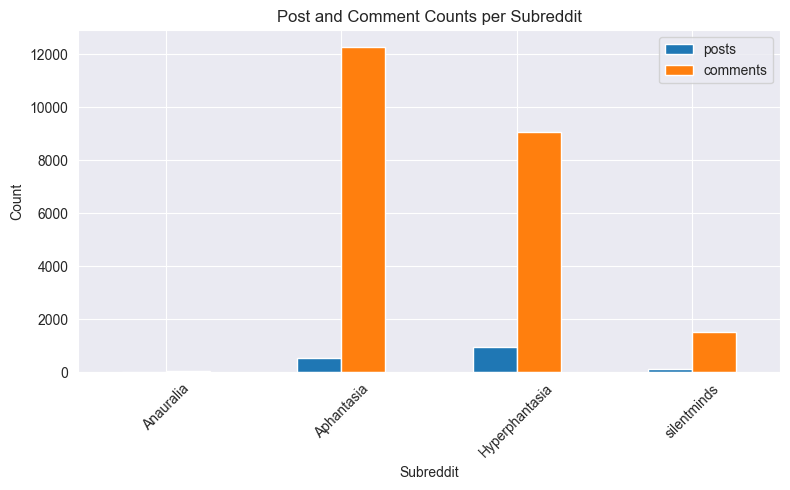

In [173]:
counts_df.plot(x="subreddit", kind="bar", figsize=(8, 5))
plt.title("Post and Comment Counts per Subreddit")
plt.ylabel("Count")
plt.xlabel("Subreddit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## post_df and comment_df

In [3]:
comment_counts = df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")
posts_df = df.drop_duplicates(subset="post_id")[["subreddit", "post_id", "post_title", "post_body", "post_author", "post_timestamp", "post_score", "permalink"]].reset_index(drop=True)
posts_df = posts_df.merge(comment_counts, on="post_id", how="left")

comments_df = df[["comment_id", "post_id", "subreddit", "comment_author", "comment_timestamp","comment_body", "comment_score", "depth", "is_top_level", "parent_id", "parent_raw", "permalink"]].copy()

In [99]:
posts_df

subreddit  post_id                                         post_title  \
0      Aphantasia  1logpyp                  "What color pops up in your mind"   
1      Aphantasia  1lodd5r                     I strive to be a great artist.   
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
3      Aphantasia  1locku0  Looking for a specific version of the apple di...   
4      Aphantasia  1lobpsq                           I don‘t see red, do you?   
...           ...      ...                                                ...   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1610  silentminds  188obgx                             I think I belong here?   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   
1613  silentminds  18190ox     At the extreme end of the Aphantasia spectrum?   

                                              post_body       post_author  \
0     I recently had an interesting moment that made...  PassionFruit4020   
1     I've recently found out I'm closer to the "ful...            KoreQQ   
2                                             Thoughts?   Sobergirlaudrey   
3     I can't recall where, but awhile ago I saw the...       okipokidoki   
4     Helli fellow Aphants,\n\nwhile doomscrolling i...        DesAnderes   
...                                                 ...               ...   
1609  Freud's Three Levels of Mind, and many other m...           NITSIRK   
1610  So I never have a running stream of thoughts i...    CaryGrantastic   
1611  Instead of mum and dad, my first words were “o...           NITSIRK   
1612                                                NaN     SummoningSelf   
1613  Aphantasia often seems to stop right there. No...           NITSIRK   

           post_timestamp  post_score  \
0     2025-06-30 20:26:13          10   
1     2025-06-30 18:18:11           4   
2     2025-06-30 18:10:02           0   
3     2025-06-30 17:49:11           4   
4     2025-06-30 17:15:45         323   
...                   ...         ...   
1609  2023-12-03 15:00:20           5   
1610  2023-12-01 22:28:08           9   
1611  2023-11-25 15:37:52           5   
1612  2023-11-24 12:23:37           4   
1613  2023-11-22 13:23:06           8   

                                              permalink  comment_count  
0     https://www.reddit.com/r/Aphantasia/comments/1...             24  
1     https://www.reddit.com/r/Aphantasia/comments/1...              3  
2     https://www.reddit.com/r/Aphantasia/comments/1...             25  
3     https://www.reddit.com/r/Aphantasia/comments/1...              1  
4     https://www.reddit.com/r/Aphantasia/comments/1...            165  
...                                                 ...            ...  
1609  https://www.reddit.com/r/silentminds/comments/...             10  
1610  https://www.reddit.com/r/silentminds/comments/...              4  
1611  https://www.reddit.com/r/silentminds/comments/...              2  
1612  https://www.reddit.com/r/silentminds/comments/...              5  
1613  https://www.reddit.com/r/silentminds/comments/...              9  

[1614 rows x 9 columns]

In [100]:
comments_df

comment_id  post_id    subreddit        comment_author  \
0        n0mrot0  1logpyp   Aphantasia          SonOfMrSpock   
1        n0mt3za  1logpyp   Aphantasia             majandess   
2        n0opsuu  1logpyp   Aphantasia  Miserable_Smoke_6719   
3        n0mu4yk  1logpyp   Aphantasia   FlightOfTheDiscords   
4        n0qceis  1logpyp   Aphantasia     Haunting_Pear8052   
...          ...      ...          ...                   ...   
22878    kbpaf1q  18190ox  silentminds               AMorera   
22879    khb9as9  18190ox  silentminds                no1nos   
22880    kbpbx4k  18190ox  silentminds               NITSIRK   
22881    kbpeasa  18190ox  silentminds               AMorera   
22882    kbpeulq  18190ox  silentminds               NITSIRK   

         comment_timestamp                                       comment_body  \
0      2025-06-30 20:34:17  I know sky-blue is my favorite color. Other th...   
1      2025-06-30 20:41:29  I can "feel" colors. \n\nI knew, for example, ...   
2      2025-07-01 02:50:13  I get a sense of colors but it’s not visual. L...   
3      2025-06-30 20:46:36  I can feel colours with other people, but not ...   
4      2025-07-01 10:47:50  I think I know exactly what you mean! I mostly...   
...                    ...                                                ...   
22878  2023-12-02 17:15:32  Kinda, yeah. Maybe I don’t understand subvocal...   
22879  2024-01-11 03:29:41  I think I can activate verbal thought in my he...   
22880  2023-12-02 17:25:36  Theres different ways of using your vocal chor...   
22881  2023-12-02 17:41:21  Yeah. I just use my vocal chords most of the t...   
22882  2023-12-02 17:45:01  Yeah, Im also AuDHD, so totally get you. I don...   

       comment_score  depth  is_top_level parent_id  parent_raw  \
0                  6      0             1   1logpyp  t3_1logpyp   
1                  7      0             1   1logpyp  t3_1logpyp   
2                  4      0             1   1logpyp  t3_1logpyp   
3                  2      0             1   1logpyp  t3_1logpyp   
4                  2      0             1   1logpyp  t3_1logpyp   
...              ...    ...           ...       ...         ...   
22878              1      4             0   kbp9n51  t1_kbp9n51   
22879              2      5             0   kbpaf1q  t1_kbpaf1q   
22880              1      5             0   kbpaf1q  t1_kbpaf1q   
22881              1      6             0   kbpbx4k  t1_kbpbx4k   
22882              1      7             0   kbpeasa  t1_kbpeasa   

                                               permalink  
0      https://www.reddit.com/r/Aphantasia/comments/1...  
1      https://www.reddit.com/r/Aphantasia/comments/1...  
2      https://www.reddit.com/r/Aphantasia/comments/1...  
3      https://www.reddit.com/r/Aphantasia/comments/1...  
4      https://www.reddit.com/r/Aphantasia/comments/1...  
...                                                  ...  
22878  https://www.reddit.com/r/silentminds/comments/...  
22879  https://www.reddit.com/r/silentminds/comments/...  
22880  https://www.reddit.com/r/silentminds/comments/...  
22881  https://www.reddit.com/r/silentminds/comments/...  
22882  https://www.reddit.com/r/silentminds/comments/...  

[22883 rows x 12 columns]

In [196]:
comments_df["text_length_word"] = comments_df["comment_body"].astype(str).apply(lambda x: len(x.split()))
# 平均长度
avg_word_len = comments_df["text_length_word"].mean()
print(f"平均评论长度（按词数）：{avg_word_len:.2f}")

平均评论长度（按词数）：61.76


In [101]:
posts_df[posts_df.isnull().any(axis=1)]

subreddit  post_id                                         post_title  \
10     Aphantasia  1lnlfli  I just Realized that our lives are not going t...   
98     Aphantasia  1l68by6  Visual Planning: Let's Think Only with Images ...   
116    Aphantasia  1l2w7pu  Are worded thoughts and conceptual thoughts th...   
143    Aphantasia  1kxdrm4  When you close your eyes lying down, in what w...   
173    Aphantasia  1ksanki  I suddenly understand why writing things down ...   
...           ...      ...                                                ...   
1596  silentminds  1c2vmn7  How do people think without visualization AND ...   
1599  silentminds  1bk0ihs           Suffering from Blank Mind and Auto Pilot   
1602  silentminds  1bgs495  Do we have a perception that is not bound by t...   
1605  silentminds  195umw7  Question: People without an inner monologue, w...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   

     post_body           post_author       post_timestamp  post_score  \
10         NaN        Monkeydoodless  2025-06-29 19:12:47          28   
98         NaN      Chris_in_Lijiang  2025-06-08 10:42:20           3   
116        NaN  Electronic_Wind_1674  2025-06-04 05:06:22           2   
143        NaN         kiwisushi7998  2025-05-28 11:35:42           2   
173        NaN      Obvious-Gate9046  2025-05-21 23:09:05          56   
...        ...                   ...                  ...         ...   
1596       NaN               NITSIRK  2024-04-13 07:45:39           2   
1599       NaN               NITSIRK  2024-03-21 07:01:36           1   
1602       NaN        sawdust4dinner  2024-03-17 07:43:12           2   
1605       NaN               NITSIRK  2024-01-13 18:32:33           2   
1612       NaN         SummoningSelf  2023-11-24 12:23:37           4   

                                              permalink  comment_count  
10    https://www.reddit.com/r/Aphantasia/comments/1...             36  
98    https://www.reddit.com/r/Aphantasia/comments/1...              4  
116   https://www.reddit.com/r/Aphantasia/comments/1...              5  
143   https://www.reddit.com/r/Aphantasia/comments/1...             30  
173   https://www.reddit.com/r/Aphantasia/comments/1...             14  
...                                                 ...            ...  
1596  https://www.reddit.com/r/silentminds/comments/...              2  
1599  https://www.reddit.com/r/silentminds/comments/...              1  
1602  https://www.reddit.com/r/silentminds/comments/...              5  
1605  https://www.reddit.com/r/silentminds/comments/...              6  
1612  https://www.reddit.com/r/silentminds/comments/...              5  

[100 rows x 9 columns]

In [102]:
comments_df[comments_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [comment_id, post_id, subreddit, comment_author, comment_timestamp, comment_body, comment_score, depth, is_top_level, parent_id, parent_raw, permalink]
Index: []

In [4]:
# Replace the empty value to "" to prevent errors during merge
posts_df["post_title"] = posts_df["post_title"].fillna("")
posts_df["post_body"] = posts_df["post_body"].fillna("")

# Merge two fields
posts_df["post_text"] = posts_df["post_title"].str.strip() + " " + posts_df["post_body"].str.strip()

In [19]:
posts_df

subreddit  post_id                                         post_title  \
0      Aphantasia  1logpyp                  "What color pops up in your mind"   
1      Aphantasia  1lodd5r                     I strive to be a great artist.   
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
3      Aphantasia  1locku0  Looking for a specific version of the apple di...   
4      Aphantasia  1lobpsq                           I don‘t see red, do you?   
...           ...      ...                                                ...   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1610  silentminds  188obgx                             I think I belong here?   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   
1613  silentminds  18190ox     At the extreme end of the Aphantasia spectrum?   

                                              post_body       post_author  \
0     I recently had an interesting moment that made...  PassionFruit4020   
1     I've recently found out I'm closer to the "ful...            KoreQQ   
2                                             Thoughts?   Sobergirlaudrey   
3     I can't recall where, but awhile ago I saw the...       okipokidoki   
4     Helli fellow Aphants,\n\nwhile doomscrolling i...        DesAnderes   
...                                                 ...               ...   
1609  Freud's Three Levels of Mind, and many other m...           NITSIRK   
1610  So I never have a running stream of thoughts i...    CaryGrantastic   
1611  Instead of mum and dad, my first words were “o...           NITSIRK   
1612                                                        SummoningSelf   
1613  Aphantasia often seems to stop right there. No...           NITSIRK   

           post_timestamp  post_score  \
0     2025-06-30 20:26:13          10   
1     2025-06-30 18:18:11           4   
2     2025-06-30 18:10:02           0   
3     2025-06-30 17:49:11           4   
4     2025-06-30 17:15:45         323   
...                   ...         ...   
1609  2023-12-03 15:00:20           5   
1610  2023-12-01 22:28:08           9   
1611  2023-11-25 15:37:52           5   
1612  2023-11-24 12:23:37           4   
1613  2023-11-22 13:23:06           8   

                                              permalink  comment_count  \
0     https://www.reddit.com/r/Aphantasia/comments/1...             24   
1     https://www.reddit.com/r/Aphantasia/comments/1...              3   
2     https://www.reddit.com/r/Aphantasia/comments/1...             25   
3     https://www.reddit.com/r/Aphantasia/comments/1...              1   
4     https://www.reddit.com/r/Aphantasia/comments/1...            165   
...                                                 ...            ...   
1609  https://www.reddit.com/r/silentminds/comments/...             10   
1610  https://www.reddit.com/r/silentminds/comments/...              4   
1611  https://www.reddit.com/r/silentminds/comments/...              2   
1612  https://www.reddit.com/r/silentminds/comments/...              5   
1613  https://www.reddit.com/r/silentminds/comments/...              9   

                                              post_text  
0     "What color pops up in your mind" I recently h...  
1     I strive to be a great artist. I've recently f...  
2     I think I don’t have ptsd because of my aphant...  
3     Looking for a specific version of the apple di...  
4     I don‘t see red, do you? Helli fellow Aphants,...  
...                                                 ...  
1609  Are our silent minds calling into question wha...  
1610  I think I belong here? So I never have a runni...  
1611  My first words may have been a result of my fa...  
1612  I describe myself as being Helen Keller in my ...  
1613  At the extreme end of the Aphantasia spectrum?...  

[1614 rows x 10 columns]

In [105]:
posts_df[posts_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [subreddit, post_id, post_title, post_body, post_author, post_timestamp, post_score, permalink, comment_count, post_text]
Index: []

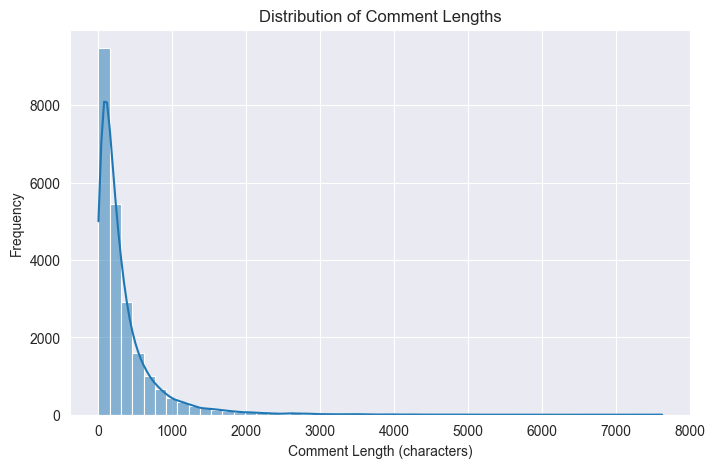

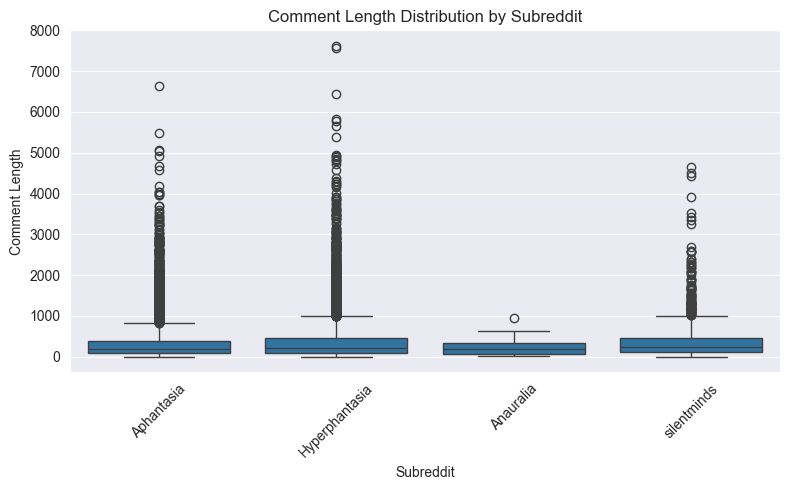

In [174]:
comments_df["comment_length"] = comments_df["comment_body"].fillna("").apply(len)

# 画直方图/密度图
plt.figure(figsize=(8,5))
sns.histplot(comments_df["comment_length"], bins=50, kde=True)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Frequency")
plt.show()

# 如果要按 subreddit 分组比较
plt.figure(figsize=(8,5))
sns.boxplot(x="subreddit", y="comment_length", data=comments_df)
plt.title("Comment Length Distribution by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Comment Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Address spam or promotional posts

In [5]:
spam_keywords = [
    r"\b(click here|buy now|free trial|limited time offer|exclusive deal|subscribe now|download now|save big|act now|get yours today)\b",
    r"(http[s]?://)?(www\.)?(bit\.ly|tinyurl\.com|t\.co|goo\.gl)",
    r"onlyfans\.com|cashapp|venmo|paypal\.me"]

def is_spam(text):

    whitelist_domains = ["doi.org", "osf.io", "reddit.com/poll", "reddit.com"]
    if any(domain in text for domain in whitelist_domains):
        return False
    for pattern in spam_keywords:
        if re.search(pattern, text, flags=re.IGNORECASE):
            return True
    return False

# Apply function tag spam post
posts_df["is_spam"] = posts_df["post_text"].apply(is_spam)

# Check out posts suspected to be spam
spam_posts = posts_df[posts_df["is_spam"] == True]
spam_posts[["post_id", "post_title", "post_text", "permalink"]]

post_id                                         post_title  \
34    1lgu5rz  Can Reading and playing chess improve and trai...   
1526  1inqqcj  Aphantasia survey for 3rd year dissertation pr...   
1608  18agnnt  Multisensory subtypes of aphantasia: Mental im...   

                                              post_text  \
34    Can Reading and playing chess improve and trai...   
1526  Aphantasia survey for 3rd year dissertation pr...   
1608  Multisensory subtypes of aphantasia: Mental im...   

                                              permalink  
34    https://www.reddit.com/r/Aphantasia/comments/1...  
1526  https://www.reddit.com/r/silentminds/comments/...  
1608  https://www.reddit.com/r/silentminds/comments/...

## Text Normalisation and Tokenize

In [122]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.8 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [59]:
nltk.download('punkt_tab')
nltk.download("stopwords")

# Loda Spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /Users/jinzi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jinzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
# Reddit stopwords
reddit_stopwords = {"lol", "idk", "pls", "tbh", "smh", "lmao", "omg",     # 代词/虚词
    "i", "im", "ive", "m", "s", "ve", "re", "ll",
    # 助动词/否定/高频动词
    "do", "did", "does", "didnt", "dont", "cant", "not", "isnt", "wasnt",
    "get", "got", "make", "made", "know", "think", "like", "would", "could", "also",
    # 泛指/低信息量词
    "thing", "things", "people", "one", "time", "day", "really", "just", "also","something", "try", "even", "anyone", "say", "go", "way", "well", "use"}

stop_words = set(stopwords.words("english")).union(reddit_stopwords)

def clean_and_tokenize(text):
    if not isinstance(text, str):
        return []
    
    # 1. Turn lowercase
    text = text.lower()

    # 2. Remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # 3. tokenize
    tokens = word_tokenize(text)

    # 4. remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 5. Lemmatize
    doc = nlp(" ".join(tokens))
    lemmas = [tok.lemma_ for tok in doc if tok.lemma_ not in stop_words and len(tok.lemma_) > 2]

    return lemmas

In [187]:
posts_df["post_text_tokens"] = posts_df["post_text"].apply(clean_and_tokenize)
comments_df["comment_text_tokens"] = comments_df["comment_body"].apply(clean_and_tokenize)

In [10]:
posts_df

subreddit  post_id                                         post_title  \
0      Aphantasia  1logpyp                  "What color pops up in your mind"   
1      Aphantasia  1lodd5r                     I strive to be a great artist.   
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
3      Aphantasia  1locku0  Looking for a specific version of the apple di...   
4      Aphantasia  1lobpsq                           I don‘t see red, do you?   
...           ...      ...                                                ...   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1610  silentminds  188obgx                             I think I belong here?   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   
1613  silentminds  18190ox     At the extreme end of the Aphantasia spectrum?   

                                              post_body       post_author  \
0     I recently had an interesting moment that made...  PassionFruit4020   
1     I've recently found out I'm closer to the "ful...            KoreQQ   
2                                             Thoughts?   Sobergirlaudrey   
3     I can't recall where, but awhile ago I saw the...       okipokidoki   
4     Helli fellow Aphants,\n\nwhile doomscrolling i...        DesAnderes   
...                                                 ...               ...   
1609  Freud's Three Levels of Mind, and many other m...           NITSIRK   
1610  So I never have a running stream of thoughts i...    CaryGrantastic   
1611  Instead of mum and dad, my first words were “o...           NITSIRK   
1612                                                        SummoningSelf   
1613  Aphantasia often seems to stop right there. No...           NITSIRK   

           post_timestamp  post_score  \
0     2025-06-30 20:26:13          10   
1     2025-06-30 18:18:11           4   
2     2025-06-30 18:10:02           0   
3     2025-06-30 17:49:11           4   
4     2025-06-30 17:15:45         323   
...                   ...         ...   
1609  2023-12-03 15:00:20           5   
1610  2023-12-01 22:28:08           9   
1611  2023-11-25 15:37:52           5   
1612  2023-11-24 12:23:37           4   
1613  2023-11-22 13:23:06           8   

                                              permalink  comment_count  \
0     https://www.reddit.com/r/Aphantasia/comments/1...             24   
1     https://www.reddit.com/r/Aphantasia/comments/1...              3   
2     https://www.reddit.com/r/Aphantasia/comments/1...             25   
3     https://www.reddit.com/r/Aphantasia/comments/1...              1   
4     https://www.reddit.com/r/Aphantasia/comments/1...            165   
...                                                 ...            ...   
1609  https://www.reddit.com/r/silentminds/comments/...             10   
1610  https://www.reddit.com/r/silentminds/comments/...              4   
1611  https://www.reddit.com/r/silentminds/comments/...              2   
1612  https://www.reddit.com/r/silentminds/comments/...              5   
1613  https://www.reddit.com/r/silentminds/comments/...              9   

                                              post_text  is_spam  \
0     "What color pops up in your mind" I recently h...    False   
1     I strive to be a great artist. I've recently f...    False   
2     I think I don’t have ptsd because of my aphant...    False   
3     Looking for a specific version of the apple di...    False   
4     I don‘t see red, do you? Helli fellow Aphants,...    False   
...                                                 ...      ...   
1609  Are our silent minds calling into question wha...    False   
1610  I think I belong here? So I never have a runni...    False   
1611  My first words may have been a result of my fa...    False   
1612  I describe myself as being Helen Keller in

In [7]:
comments_df

comment_id  post_id    subreddit        comment_author  \
0        n0mrot0  1logpyp   Aphantasia          SonOfMrSpock   
1        n0mt3za  1logpyp   Aphantasia             majandess   
2        n0opsuu  1logpyp   Aphantasia  Miserable_Smoke_6719   
3        n0mu4yk  1logpyp   Aphantasia   FlightOfTheDiscords   
4        n0qceis  1logpyp   Aphantasia     Haunting_Pear8052   
...          ...      ...          ...                   ...   
22878    kbpaf1q  18190ox  silentminds               AMorera   
22879    khb9as9  18190ox  silentminds                no1nos   
22880    kbpbx4k  18190ox  silentminds               NITSIRK   
22881    kbpeasa  18190ox  silentminds               AMorera   
22882    kbpeulq  18190ox  silentminds               NITSIRK   

         comment_timestamp                                       comment_body  \
0      2025-06-30 20:34:17  I know sky-blue is my favorite color. Other th...   
1      2025-06-30 20:41:29  I can "feel" colors. \n\nI knew, for example, ...   
2      2025-07-01 02:50:13  I get a sense of colors but it’s not visual. L...   
3      2025-06-30 20:46:36  I can feel colours with other people, but not ...   
4      2025-07-01 10:47:50  I think I know exactly what you mean! I mostly...   
...                    ...                                                ...   
22878  2023-12-02 17:15:32  Kinda, yeah. Maybe I don’t understand subvocal...   
22879  2024-01-11 03:29:41  I think I can activate verbal thought in my he...   
22880  2023-12-02 17:25:36  Theres different ways of using your vocal chor...   
22881  2023-12-02 17:41:21  Yeah. I just use my vocal chords most of the t...   
22882  2023-12-02 17:45:01  Yeah, Im also AuDHD, so totally get you. I don...   

       comment_score  depth  is_top_level parent_id  parent_raw  \
0                  6      0             1   1logpyp  t3_1logpyp   
1                  7      0             1   1logpyp  t3_1logpyp   
2                  4      0             1   1logpyp  t3_1logpyp   
3                  2      0             1   1logpyp  t3_1logpyp   
4                  2      0             1   1logpyp  t3_1logpyp   
...              ...    ...           ...       ...         ...   
22878              1      4             0   kbp9n51  t1_kbp9n51   
22879              2      5             0   kbpaf1q  t1_kbpaf1q   
22880              1      5             0   kbpaf1q  t1_kbpaf1q   
22881              1      6             0   kbpbx4k  t1_kbpbx4k   
22882              1      7             0   kbpeasa  t1_kbpeasa   

                                               permalink  
0      https://www.reddit.com/r/Aphantasia/comments/1...  
1      https://www.reddit.com/r/Aphantasia/comments/1...  
2      https://www.reddit.com/r/Aphantasia/comments/1...  
3      https://www.reddit.com/r/Aphantasia/comments/1...  
4      https://www.reddit.com/r/Aphantasia/comments/1...  
...                                                  ...  
22878  https://www.reddit.com/r/silentminds/comments/...  
22879  https://www.reddit.com/r/silentminds/comments/...  
22880  https://www.reddit.com/r/silentminds/comments/...  
22881  https://www.reddit.com/r/silentminds/comments/...  
22882  https://www.reddit.com/r/silentminds/comments/...  

[22883 rows x 12 columns]

### Average Words Count in Post and Comment

In [25]:
# Calculate the number of tokens per post
posts_df["token_count"] = posts_df["post_text_tokens"].apply(len)

# Calculate the number of tokens per comment
comments_df["token_count"] = comments_df["comment_text_tokens"].apply(len)

# Check the result
print("Posts token quantity distribution：")
print(posts_df["token_count"].describe())

print("\nComment token quantity distribution：")
print(comments_df["token_count"].describe())


Posts token quantity distribution：
count    1614.000000
mean       79.090458
std        99.401304
min         1.000000
25%        28.000000
50%        56.000000
75%        98.000000
max      1858.000000
Name: token_count, dtype: float64

Comment token quantity distribution：
count    22883.000000
mean        31.952410
std         42.244896
min          0.000000
25%          8.000000
50%         19.000000
75%         39.000000
max        707.000000
Name: token_count, dtype: float64


## View extreme outlier

### anauralia

In [70]:
anauralia_df = df[df["subreddit"] == "Anauralia"]

# Post Score
anauralia_post_scores = anauralia_df.drop_duplicates(subset="post_id")[["post_id", "post_title", "post_body", "post_score"]].copy()

# Post Comment Number
anauralia_comment_counts = anauralia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")

# Comment Score
anauralia_comment_likes = anauralia_df[["comment_id", "comment_score", "post_id"]].drop_duplicates(subset="comment_id")

merged = pd.merge(anauralia_post_scores, anauralia_comment_counts, on="post_id")
merged

post_id                                         post_title  \
0  1jcx5nh            How do you call someone with anauralia?   
1  1iahy5t          University Questionnaire Research Project   
2  1i3ht95  Participate in Our Study on Anauralia and Apha...   
3  1hw4tnv        can u can anauralia and an inner narration?   
4  1hdho6b                                 Research-anauralia   
5  154ekx2                What exactly constitutes Anauralia?   
6  10qezf2                                         Meditation   
7  10ougkm                                Talking to yourself   

                                           post_body  post_score  \
0  I know that the term 'aphant' is for people wi...           2   
1  Hello.\n\n \n\nA psychology student from the U...           1   
2  Hello everyone,\n\nI am reaching out on behalf...           2   
3  i have an inner narration (some ppl call it in...           3   
4  Hello, I am a student research Anauralia as pa...           1   
5  I can whisper to myself in my mind if I consci...           3   
6  I meditate EXTREMELY easily. Clearing my head ...           1   
7  Hi all. My whole life I've 'thought out loud' ...           6   

   comment_count  
0              3  
1              2  
2              2  
3              4  
4              5  
5              4  
6              4  
7              6

In [71]:
anauralia_comment_likes = anauralia_comment_likes.sort_values(by="comment_score", ascending=False)
anauralia_comment_likes

comment_id  comment_score  post_id
21348    ml9r43u              3  1jcx5nh
21364    jsvgb7j              3  154ekx2
21368    kp02eaf              3  10qezf2
21355    m5ygloy              3  1hw4tnv
21365    l20et7e              3  154ekx2
21376    j6pqo1e              2  10ougkm
21374    j6pjk8z              2  10ougkm
21373    j6pjhk9              2  10ougkm
21370    kp02mpo              2  10qezf2
21366    l4lzkzu              2  154ekx2
21377    j6qtymn              2  10ougkm
21359    m1w5h8i              1  1hdho6b
21369    j6wlwcg              1  10qezf2
21350    miwsuyz              1  1jcx5nh
21375    j6plcrk              1  10ougkm
21351    m9bplpq              1  1iahy5t
21352    m9hmzgg              1  1iahy5t
21372    j6pg91z              1  10ougkm
21371    j6wxy1e              1  10qezf2
21353    m7vi8hn              1  1i3ht95
21354    m8n4ts6              1  1i3ht95
21360    m1wcc7x              1  1hdho6b
21367    n0g3w05              1  154ekx2
21356    m5yw3ke              1  1hw4tnv
21357    moezpcf              1  1hw4tnv
21358    m5ywf0q              1  1hw4tnv
21349    mivrhbt              1  1jcx5nh
21362    m1w69tz              1  1hdho6b
21361    m1werwj              1  1hdho6b
21363    m1wfk9n              1  1hdho6b

### aphantasia

In [62]:
aphantasia_df = df[df["subreddit"] == "Aphantasia"]

# Post Score
aphantasia_post_scores = aphantasia_df.drop_duplicates(subset="post_id")[["post_id", "post_title", "post_body", "post_score"]].copy()

# Post Comment Number
aphantasia_comment_counts = aphantasia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")

# Comment Score
aphantasia_comment_likes = aphantasia_df[["comment_id", "comment_score", "post_id"]].drop_duplicates(subset="comment_id")

merged = pd.merge(aphantasia_post_scores, aphantasia_comment_counts, on="post_id")
merged

post_id                                         post_title  \
0    1logpyp                  "What color pops up in your mind"   
1    1lodd5r                     I strive to be a great artist.   
2    1lod57d  I think I don’t have ptsd because of my aphant...   
3    1locku0  Looking for a specific version of the apple di...   
4    1lobpsq                           I don‘t see red, do you?   
..       ...                                                ...   
536  1j8e2vs                                             Taste?   
537  1j8caod  Research for the efficacy of mindfulness based...   
538  1j85ixw               Lack of memory and feeling of self ?   
539  1j85id1  Did anyone else discover other neurodivergent ...   
540  1j84kqs                                 No thoughts at all   

                                             post_body  post_score  \
0    I recently had an interesting moment that made...          10   
1    I've recently found out I'm closer to the "ful...           4   
2                                            Thoughts?           0   
3    I can't recall where, but awhile ago I saw the...           4   
4    Helli fellow Aphants,\n\nwhile doomscrolling i...         323   
..                                                 ...         ...   
536  So people with aphantasia, when someone tells ...           6   
537  I am a graduate student in the Psychology Depa...          19   
538  I have seen many posts here about how many of ...          24   
539  About six months ago, I discovered about Aphan...          23   
540  I have full-blown aphantasia (all senses) and ...          23   

     comment_count  
0               24  
1                3  
2               25  
3                1  
4              165  
..             ...  
536             32  
537             26  
538             16  
539             22  
540             23  

[541 rows x 5 columns]

In [63]:
aphantasia_comment_likes = aphantasia_comment_likes.sort_values(by="comment_score", ascending=False)
aphantasia_comment_likes

comment_id  comment_score  post_id
53      n0lmt73            843  1lobpsq
6742    mp61re3            416  1k8gmci
164     n0lokcm            325  1lobpsq
6743    mp69wfy            279  1k8gmci
4294    mt3z50i            238  1kq9ool
...         ...            ...      ...
1994    mwygr16            -18  1l7oe0m
9328    mmdnd0z            -18  1jvwbv7
1974    mwyfjb7            -20  1l7oe0m
180     n0lo3ng            -24  1lobpsq
9287    mme8wvd            -25  1jvyvm2

[12284 rows x 3 columns]

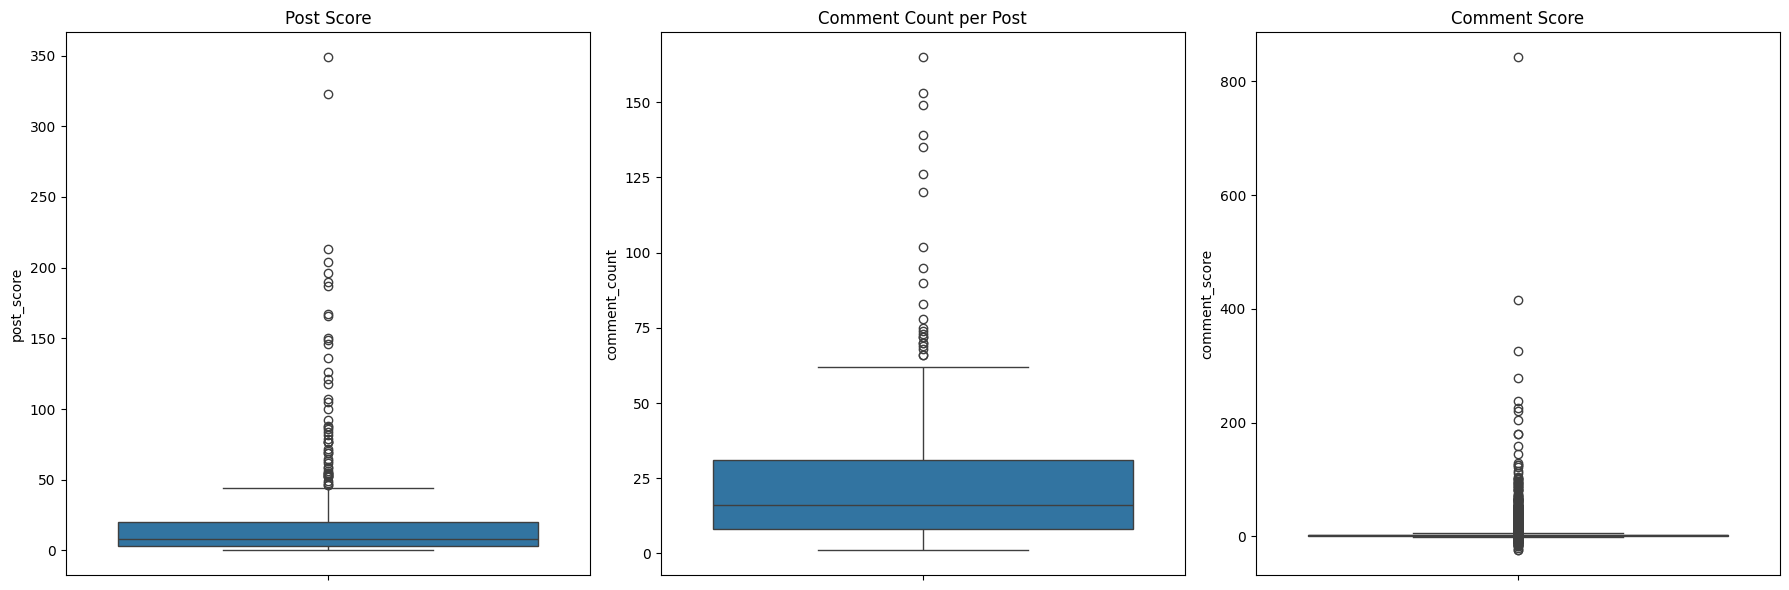

In [67]:
# boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(y=aphantasia_post_scores["post_score"], ax=axes[0])
axes[0].set_title("Post Score")

sns.boxplot(y=aphantasia_comment_counts["comment_count"], ax=axes[1])
axes[1].set_title("Comment Count per Post")

sns.boxplot(y=aphantasia_comment_likes["comment_score"], ax=axes[2])
axes[2].set_title("Comment Score")

plt.tight_layout()
plt.show()

### hyperphantasia

In [ ]:
hyperphantasia_df = df[df["subreddit"] == "Hyperphantasia"]

# Post Score
hyperphantasia_post_scores = hyperphantasia_df.drop_duplicates(subset="post_id")[["post_id", "post_title", "post_body", "post_score"]].copy()

# Post Comment Number
hyperphantasia_comment_counts = hyperphantasia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")

# Comment Score
hyperphantasia_comment_likes = hyperphantasia_df[["comment_id", "comment_score", "post_id"]].drop_duplicates(subset="comment_id")

merged = pd.merge(aphantasia_post_scores, aphantasia_comment_counts, on="post_id")
merged

## Anonymous username

In [8]:
# hash function
def hash_username(username):
    if pd.isna(username):
        return "anonymous"
    return hashlib.sha256(username.encode('utf-8')).hexdigest()[:10]

posts_df["anonymous_user"] = posts_df["post_author"].apply(hash_username)

comments_df["anonymous_user"] = comments_df["comment_author"].apply(hash_username)


In [9]:
posts_df

subreddit  post_id                                         post_title  \
0      Aphantasia  1logpyp                  "What color pops up in your mind"   
1      Aphantasia  1lodd5r                     I strive to be a great artist.   
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
3      Aphantasia  1locku0  Looking for a specific version of the apple di...   
4      Aphantasia  1lobpsq                           I don‘t see red, do you?   
...           ...      ...                                                ...   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1610  silentminds  188obgx                             I think I belong here?   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   
1613  silentminds  18190ox     At the extreme end of the Aphantasia spectrum?   

                                              post_body       post_author  \
0     I recently had an interesting moment that made...  PassionFruit4020   
1     I've recently found out I'm closer to the "ful...            KoreQQ   
2                                             Thoughts?   Sobergirlaudrey   
3     I can't recall where, but awhile ago I saw the...       okipokidoki   
4     Helli fellow Aphants,\n\nwhile doomscrolling i...        DesAnderes   
...                                                 ...               ...   
1609  Freud's Three Levels of Mind, and many other m...           NITSIRK   
1610  So I never have a running stream of thoughts i...    CaryGrantastic   
1611  Instead of mum and dad, my first words were “o...           NITSIRK   
1612                                                        SummoningSelf   
1613  Aphantasia often seems to stop right there. No...           NITSIRK   

           post_timestamp  post_score  \
0     2025-06-30 20:26:13          10   
1     2025-06-30 18:18:11           4   
2     2025-06-30 18:10:02           0   
3     2025-06-30 17:49:11           4   
4     2025-06-30 17:15:45         323   
...                   ...         ...   
1609  2023-12-03 15:00:20           5   
1610  2023-12-01 22:28:08           9   
1611  2023-11-25 15:37:52           5   
1612  2023-11-24 12:23:37           4   
1613  2023-11-22 13:23:06           8   

                                              permalink  comment_count  \
0     https://www.reddit.com/r/Aphantasia/comments/1...             24   
1     https://www.reddit.com/r/Aphantasia/comments/1...              3   
2     https://www.reddit.com/r/Aphantasia/comments/1...             25   
3     https://www.reddit.com/r/Aphantasia/comments/1...              1   
4     https://www.reddit.com/r/Aphantasia/comments/1...            165   
...                                                 ...            ...   
1609  https://www.reddit.com/r/silentminds/comments/...             10   
1610  https://www.reddit.com/r/silentminds/comments/...              4   
1611  https://www.reddit.com/r/silentminds/comments/...              2   
1612  https://www.reddit.com/r/silentminds/comments/...              5   
1613  https://www.reddit.com/r/silentminds/comments/...              9   

                                              post_text  is_spam  \
0     "What color pops up in your mind" I recently h...    False   
1     I strive to be a great artist. I've recently f...    False   
2     I think I don’t have ptsd because of my aphant...    False   
3     Looking for a specific version of the apple di...    False   
4     I don‘t see red, do you? Helli fellow Aphants,...    False   
...                                                 ...      ...   
1609  Are our silent minds calling into question wha...    False   
1610  I think I belong here? So I never have a runni...    False   
1611  My first words may have been a result of my fa...    False   
1612  I describe myself as being Helen Keller in

In [137]:
comments_df

comment_id  post_id    subreddit        comment_author  \
0        n0mrot0  1logpyp   Aphantasia          SonOfMrSpock   
1        n0mt3za  1logpyp   Aphantasia             majandess   
2        n0opsuu  1logpyp   Aphantasia  Miserable_Smoke_6719   
3        n0mu4yk  1logpyp   Aphantasia   FlightOfTheDiscords   
4        n0qceis  1logpyp   Aphantasia     Haunting_Pear8052   
...          ...      ...          ...                   ...   
22878    kbpaf1q  18190ox  silentminds               AMorera   
22879    khb9as9  18190ox  silentminds                no1nos   
22880    kbpbx4k  18190ox  silentminds               NITSIRK   
22881    kbpeasa  18190ox  silentminds               AMorera   
22882    kbpeulq  18190ox  silentminds               NITSIRK   

         comment_timestamp                                       comment_body  \
0      2025-06-30 20:34:17  I know sky-blue is my favorite color. Other th...   
1      2025-06-30 20:41:29  I can "feel" colors. \n\nI knew, for example, ...   
2      2025-07-01 02:50:13  I get a sense of colors but it’s not visual. L...   
3      2025-06-30 20:46:36  I can feel colours with other people, but not ...   
4      2025-07-01 10:47:50  I think I know exactly what you mean! I mostly...   
...                    ...                                                ...   
22878  2023-12-02 17:15:32  Kinda, yeah. Maybe I don’t understand subvocal...   
22879  2024-01-11 03:29:41  I think I can activate verbal thought in my he...   
22880  2023-12-02 17:25:36  Theres different ways of using your vocal chor...   
22881  2023-12-02 17:41:21  Yeah. I just use my vocal chords most of the t...   
22882  2023-12-02 17:45:01  Yeah, Im also AuDHD, so totally get you. I don...   

       comment_score  depth  is_top_level parent_id  parent_raw  \
0                  6      0             1   1logpyp  t3_1logpyp   
1                  7      0             1   1logpyp  t3_1logpyp   
2                  4      0             1   1logpyp  t3_1logpyp   
3                  2      0             1   1logpyp  t3_1logpyp   
4                  2      0             1   1logpyp  t3_1logpyp   
...              ...    ...           ...       ...         ...   
22878              1      4             0   kbp9n51  t1_kbp9n51   
22879              2      5             0   kbpaf1q  t1_kbpaf1q   
22880              1      5             0   kbpaf1q  t1_kbpaf1q   
22881              1      6             0   kbpbx4k  t1_kbpbx4k   
22882              1      7             0   kbpeasa  t1_kbpeasa   

                                               permalink  is_spam  \
0      https://www.reddit.com/r/Aphantasia/comments/1...    False   
1      https://www.reddit.com/r/Aphantasia/comments/1...    False   
2      https://www.reddit.com/r/Aphantasia/comments/1...    False   
3      https://www.reddit.com/r/Aphantasia/comments/1...    False   
4      https://www.reddit.com/r/Aphantasia/comments/1...    False   
...                                                  ...      ...   
22878  https://www.reddit.com/r/silentminds/comments/...    False   
22879  https://www.reddit.com/r/silentminds/comments/...    False   
22880  https://www.reddit.com/r/silentminds/comments/...    False   
22881  https://www.reddit.com/r/silentminds/comments/...    False   
22882  https://www.reddit.com/r/silentminds/comments/...    False   

                                     comment_text_tokens anonymous_user  
0      [know, skyblue, favorite, color, can, not, pic...     14cca98559  
1      [feel, color, know, example, want, stain, fire...     4407c0a16a  
2      [get, sense, color, visual, like, I, m, store,...     97c139dd7c  
3      [feel, colour, people, someone, else, need, co...     f837fe9836  
4      [think, know, exactly, mean, mostly, also, dec...     1a9caa11e8  
...                                                  ...            ...  
22878  [kinda, yeah, maybe, do, not, understand, subv...     9fc9f3fce2  
22879  [think, activate, verbal, thoug

## Comments in each subreddit

In [44]:
anauralia_df = df[df["subreddit"] == "Anauralia"]

anauralia_comment = anauralia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")
anauralia_comment_sorted = anauralia_comment.sort_values(by="comment_count", ascending=False)
anauralia_comment_sorted

post_id  comment_count
0  10ougkm              6
3  1hdho6b              5
1  10qezf2              4
4  1hw4tnv              4
2  154ekx2              3
7  1jcx5nh              3
5  1i3ht95              2
6  1iahy5t              2

In [43]:
aphantasia_df = df[df["subreddit"] == "Aphantasia"]

aphantasia_comment = aphantasia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")
aphantasia_comment_sorted = aphantasia_comment.sort_values(by="comment_count", ascending=False)
aphantasia_comment_sorted

post_id  comment_count
144  1k1y4bf            153
257  1ki7hmg            149
170  1k43dmr            139
194  1k8gmci            135
36   1jolcap            126
..       ...            ...
271  1kiygv9              1
410  1l83cft              1
148  1k2crfg              1
421  1l9dxa5              1
20   1jiw90t              1

[454 rows x 2 columns]

In [45]:
hyperphantasia_df = df[df["subreddit"] == "Hyperphantasia"]

hyperphantasia_comment = hyperphantasia_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")
hyperphantasia_comment_sorted = hyperphantasia_comment.sort_values(by="comment_count", ascending=False)
hyperphantasia_comment_sorted

post_id  comment_count
128  13i9sf2             85
434  1bjuaig             79
614  1groijd             74
763  1j8rmv6             68
500  1cmav7c             68
..       ...            ...
643  1hbcslx              1
243  16yk6ne              1
627  1h53bgd              1
610  1gpnh97              1
0    100em0u              1

[935 rows x 2 columns]

In [47]:
silentminds_df = df[df["subreddit"] == "silentminds"]

silentminds_comment = silentminds_df.groupby("post_id")["comment_id"].nunique().reset_index(name="comment_count")
silentminds_comment_sorted = silentminds_comment.sort_values(by="comment_count", ascending=False)
silentminds_comment_sorted

post_id  comment_count
107  1jvbrlt             43
82   1ieqlnm             36
104  1jnb1au             35
35   1esz8ng             33
24   1cxvsgr             33
..       ...            ...
59   1gv118k              1
19   1c9de0n              1
21   1csgfli              1
23   1cwkqrt              1
70   1hwq5ef              1

[126 rows x 2 columns]

## high-frequency words

In [189]:
all_tokens_list = pd.concat([posts_df["post_text_tokens"], comments_df["comment_text_tokens"]]).explode().dropna()
all_word_count = Counter(all_tokens_list)
print(f"high-frequency words: {all_word_count.most_common(20)}")

high-frequency words: [('see', 9424), ('feel', 5330), ('mind', 5250), ('aphantasia', 5167), ('imagine', 4074), ('image', 3796), ('memory', 3758), ('eye', 3662), ('experience', 3600), ('visual', 3474), ('head', 3384), ('look', 3225), ('word', 3085), ('dream', 3059), ('visualize', 3040), ('remember', 2961), ('brain', 2920), ('read', 2867), ('find', 2754), ('thought', 2721)]


In [190]:
pd.DataFrame(all_word_count.most_common(100), columns=["word", "count"]).to_csv("reddit_word_freq.csv", index=False)

## Cloud Words

In [145]:
def generate_wordcloud(texts, title="Word Cloud", use_tfidf=False, max_words=100):
    # 如果是 TF-IDF 模式
    if use_tfidf:
        vectorizer = TfidfVectorizer(stop_words='english', max_features=max_words)
        tfidf_matrix = vectorizer.fit_transform(texts)
        tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))
        wc = WordCloud(width=800, height=400).generate_from_frequencies(tfidf_scores)
    else:
        full_text = " ".join(texts)
        wc = WordCloud(width=800, height=400, stopwords='english', max_words=max_words).generate(full_text)

    # 绘图
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


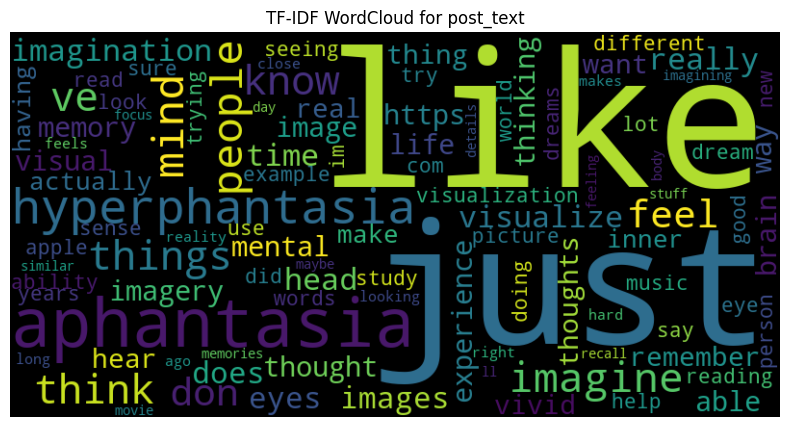

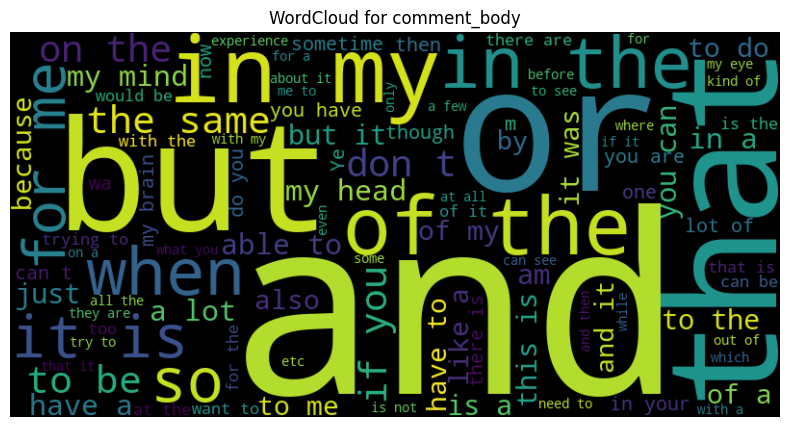

In [146]:
# 所有post_text的TF-IDF词云
generate_wordcloud(posts_df["post_text"], title="TF-IDF WordCloud for post_text", use_tfidf=True)

# 所有comment_body的普通词云
generate_wordcloud(comments_df["comment_body"], title="WordCloud for comment_body", use_tfidf=False)


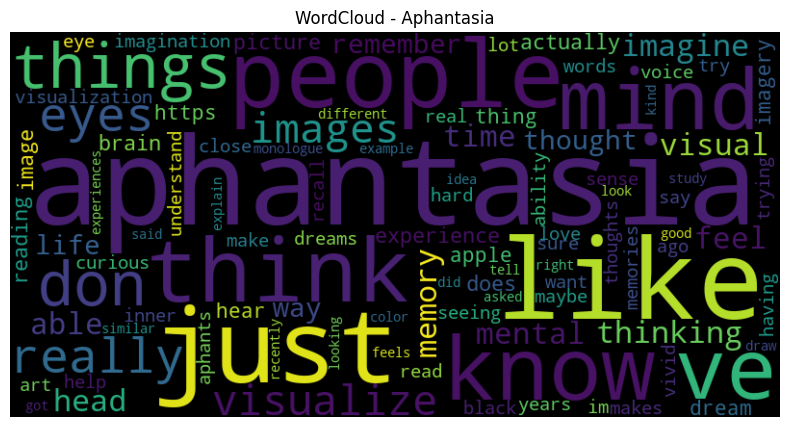

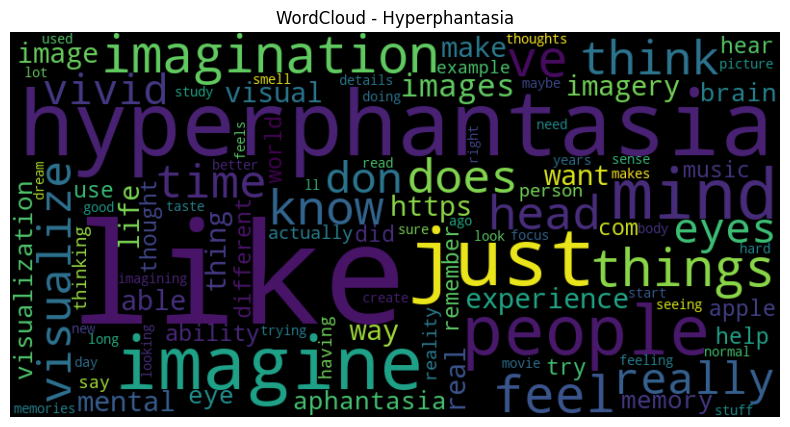

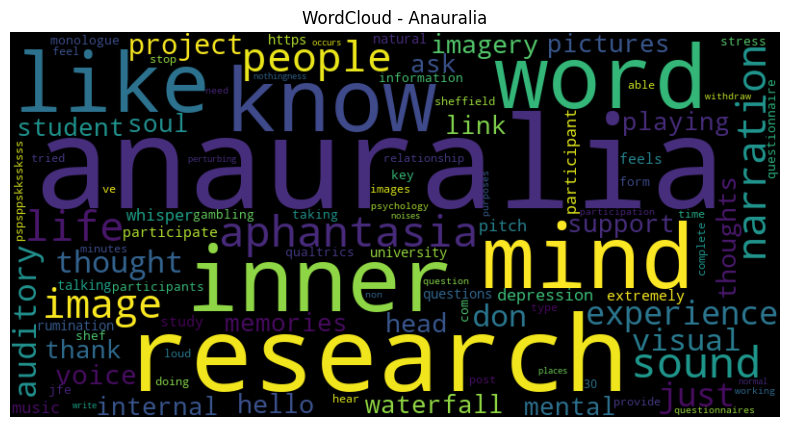

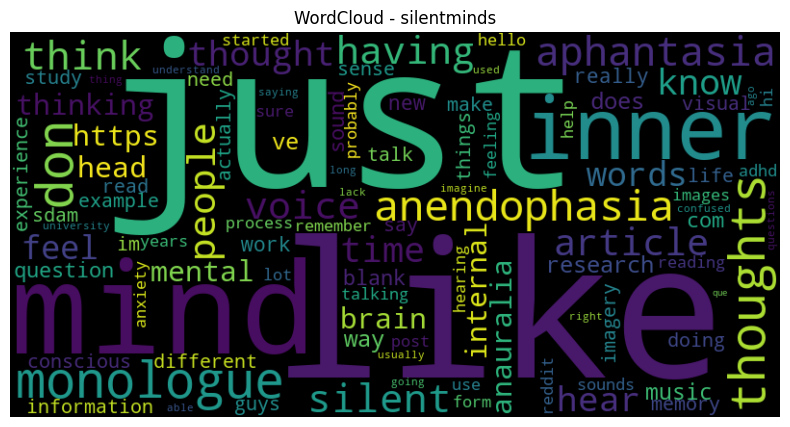

In [147]:
for subreddit in posts_df["subreddit"].unique():
    subset = posts_df[posts_df["subreddit"] == subreddit]
    generate_wordcloud(subset["post_text"], title=f"WordCloud - {subreddit}", use_tfidf=True)


# Analysis of high-frequency word differences

In [87]:
aphantasia_docs = (posts_df[posts_df["subreddit"] == "Aphantasia"]["post_text_tokens"].tolist() 
                        + comments_df[comments_df["subreddit"] == "Aphantasia"]["comment_text_tokens"].tolist())
hyperphantasia_docs = (posts_df[posts_df["subreddit"] == "Hyperphantasia"]["post_text_tokens"].tolist() 
                        + comments_df[comments_df["subreddit"] == "Hyperphantasia"]["comment_text_tokens"].tolist())
anauralia_docs = (posts_df[posts_df["subreddit"] == "Anauralia"]["post_text_tokens"].tolist() 
                        + comments_df[comments_df["subreddit"] == "Anauralia"]["comment_text_tokens"].tolist())
silentminds_docs = (posts_df[posts_df["subreddit"] == "silentminds"]["post_text_tokens"].tolist() 
                        + comments_df[comments_df["subreddit"] == "silentminds"]["comment_text_tokens"].tolist())
print(f"Numbers of aphantasia_docs: {len(aphantasia_docs)}\n"
      f"Numbers of hyperphantasia_docs: {len(hyperphantasia_docs)}\n"
      f"Numbers of anauralia_docs: {len(anauralia_docs)}\n"
      f"Numbers of silentminds_docs: {len(silentminds_docs)}")



Numbers of aphantasia_docs: 12825
Numbers of hyperphantasia_docs: 10001
Numbers of anauralia_docs: 38
Numbers of silentminds_docs: 1633


In [97]:
# 自定义停用词集合
custom_stopwords = {
    "m", "s", "ve", "re", "ll", "d", "t",
    "like", "just", "get", "go", "make", "start", "know", "really", "want"
}
clean_aphantasia_docs = [[word for word in doc if word not in custom_stopwords] for doc in aphantasia_docs]
clean_hyperphantasia_docs = [[word for word in doc if word not in custom_stopwords] for doc in hyperphantasia_docs]

In [98]:
aphant_words = [word for doc in clean_aphantasia_docs for word in doc]
hyper_words = [word for doc in clean_hyperphantasia_docs for word in doc]

aphant_freq = Counter(aphant_words)
hyper_freq = Counter(hyper_words)

aphant_hyper_words = set(aphant_freq.keys()).union(set(hyper_freq.keys()))
freq_df = pd.DataFrame({
    "word": list(aphant_hyper_words),
    "aphant_freq": [aphant_freq.get(w, 0) for w in aphant_hyper_words],
    "hyper_freq": [hyper_freq.get(w, 0) for w in aphant_hyper_words]
})
freq_df["diff_hyper_minus_aphant"] = freq_df["hyper_freq"] - freq_df["aphant_freq"]

# 排序
freq_df_sorted = freq_df.sort_values(by="diff_hyper_minus_aphant", ascending=False)
print(freq_df_sorted.head(30).to_string(index=False))

          word  aphant_freq  hyper_freq  diff_hyper_minus_aphant
hyperphantasia          175        2206                     2031
       imagine         1395        2608                     1213
   imagination          562        1429                      867
          real          543        1306                      763
          mind         2036        2646                      610
         focus          434        1012                      578
           try         1512        2021                      509
           eye         1567        2057                      490
         vivid          328         817                      489
         world          432         885                      453
          feel         2297        2742                      445
        object          237         660                      423
       reality          231         644                      413
         scene          217         629                      412
        create          3

# Topic Modeling

## LDA Analysis

In [1]:
!pip install gensim pyLDAvis
!pip install numpy==1.24.4

  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/Users/jinzi/miniconda3/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/Users/jinzi/miniconda3/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/jinzi/miniconda3/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 137, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
 

In [57]:
# import
from gensim import corpora, models
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import pyLDAvis

### Input Preparing

In [62]:
# Combine post_text_tokens and comment_text_tokens
all_docs = posts_df["post_text_tokens"].tolist() + comments_df["comment_text_tokens"].tolist()
print(f"Number of posts: {len(posts_df["post_text_tokens"])}, Number of comments: {len(comments_df["comment_text_tokens"])}")
print(f"Number of all docs: {len(all_docs)}")

number_len = 31
long_docs = [doc for doc in all_docs if len(doc) > number_len]
print(f"Number of documents greater than {number_len} tokens: {len(long_docs)}")
print(f"Percentage: {len(long_docs) / len(all_docs):.2%}")

doc_lengths = [len(doc) for doc in long_docs]
total_words = sum(doc_lengths)
print(f"Total words: {total_words}")

Number of posts: 1614, Number of comments: 22883
Number of all docs: 24497
Number of documents greater than 31 tokens: 8351
Percentage: 34.09%
Total words: 646783


In [63]:
# Add new stopwords (Depends on the result of topic modeling)
custom_stopwords = {"t", "ve", "re", "d", "m", "ll", "s", "I",
                    "also", "would", "think", "people", "get", "go", "like", "just", "know", "thing", "things", "really"}
stop_words = set(stopwords.words('english')).union(custom_stopwords)
long_docs = [[word for word in doc if word not in stop_words] for doc in long_docs]
clean_doc_lengths = [len(doc) for doc in long_docs]
clean_total_words = sum(clean_doc_lengths)
print(f"Total words: {clean_total_words}")

Total words: 542003


In [64]:
print(len(long_docs))

8351


### Generate dictionary and corpora

In [65]:
# Create dictionary
dictionary = corpora.Dictionary(long_docs)
# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Turn text to bags-of-words
corpus = [dictionary.doc2bow(text) for text in long_docs]

### Training

In [191]:
num_topics = 11
# Train LDA
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [192]:
lda_model.print_topics(num_topics, num_words=15)

[(0,
  '0.051*"see" + 0.048*"eye" + 0.028*"image" + 0.026*"visualize" + 0.023*"visualization" + 0.022*"visual" + 0.015*"close" + 0.014*"aphantasia" + 0.013*"mind" + 0.011*"experience" + 0.010*"open" + 0.009*"vision" + 0.009*"something" + 0.007*"look" + 0.007*"hallucination"'),
 (1,
  '0.047*"feel" + 0.022*"smell" + 0.020*"sense" + 0.018*"body" + 0.015*"touch" + 0.015*"taste" + 0.014*"experience" + 0.014*"imagine" + 0.013*"emotion" + 0.013*"pain" + 0.012*"sound" + 0.010*"sensation" + 0.009*"mind" + 0.008*"something" + 0.008*"feeling"'),
 (2,
  '0.026*"see" + 0.025*"imagine" + 0.014*"feel" + 0.014*"mind" + 0.011*"something" + 0.011*"make" + 0.010*"look" + 0.010*"real" + 0.010*"head" + 0.009*"imagination" + 0.008*"say" + 0.008*"even" + 0.008*"could" + 0.008*"apple" + 0.008*"world"'),
 (3,
  '0.026*"draw" + 0.021*"use" + 0.018*"work" + 0.016*"art" + 0.015*"learn" + 0.013*"skill" + 0.011*"artist" + 0.010*"look" + 0.010*"make" + 0.009*"reference" + 0.009*"practice" + 0.008*"good" + 0.007*"he

### Visualization

In [193]:
# Visualize Topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Save to html files
pyLDAvis.save_html(vis, "lda_vis_num=11.html")

### Perplexity

Evaluating topics: 100%|██████████| 28/28 [08:20<00:00, 17.89s/it]


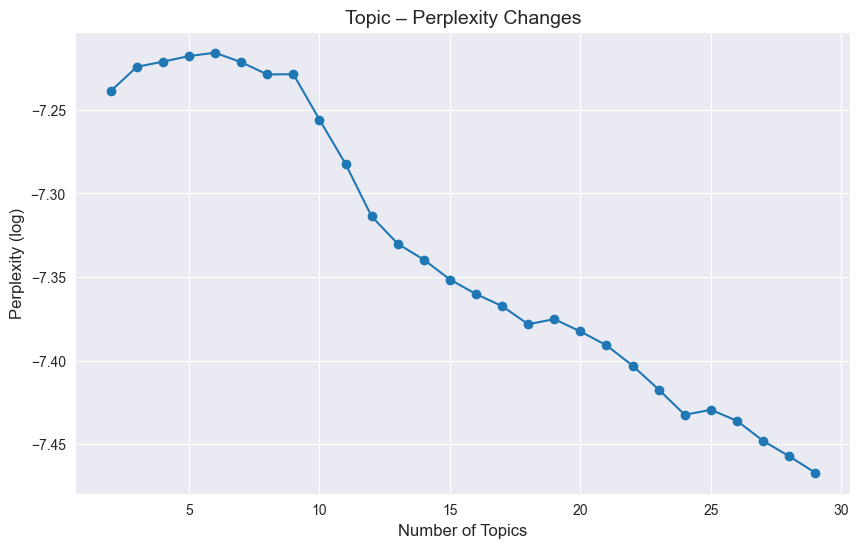

In [66]:
perplexities = []
topic_range = list(range(2, 30))  # 主题数量从 2 到 30

for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda = models.LdaModel(corpus=corpus, 
                   id2word=dictionary, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto',
                   per_word_topics=True)
    
    log_perplexity = lda.log_perplexity(corpus)
    perplexities.append(log_perplexity)  # 注意：越接近 0 越好（负值）

# 画图
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexities, marker='o')
plt.title("Topic – Perplexity Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Perplexity (log)", fontsize=12)
plt.grid(True)
plt.show()

### Coherence

In [68]:
from gensim.models import CoherenceModel

Evaluating topics: 100%|██████████| 28/28 [09:36<00:00, 20.59s/it]
/Users/jinzi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


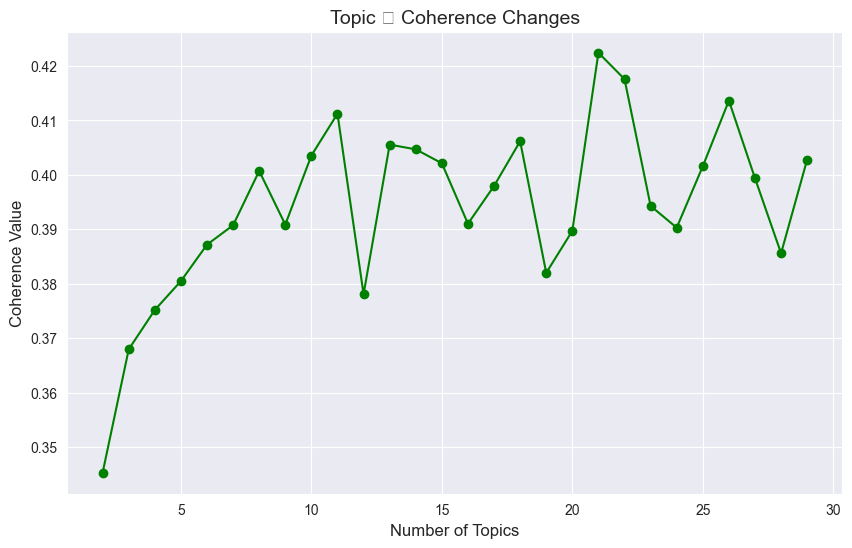

In [69]:
coherences = []

for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda = models.LdaModel(corpus=corpus, 
                   id2word=dictionary, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto')
    
    coherence_model = CoherenceModel(model=lda, texts=long_docs, dictionary=dictionary, coherence='c_v')
    score = coherence_model.get_coherence()
    coherences.append(score)

plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherences, marker='o', color='green')
plt.title("Topic 一 Coherence Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Value", fontsize=12)
plt.grid(True)
plt.show()

## Sub-corpus LDA Analysis (Hyperphantasia)
### Subreddit == Hyperphantasia

#### Input

In [64]:
hyper_subreddit_docs = (posts_df[posts_df["subreddit"] == "Hyperphantasia"]["post_text_tokens"].tolist() 
                        + comments_df[comments_df["subreddit"] == "Hyperphantasia"]["comment_text_tokens"].tolist())
print(f"Number of documents: {len(hyper_subreddit_docs)}")
number_len = 32
long_hyper_subreddit_docs = [doc for doc in hyper_subreddit_docs if len(doc) > number_len]
print(f"Number of documents greater than {number_len} tokens: {len(long_hyper_subreddit_docs)}")
print(f"Percentage: {len(long_hyper_subreddit_docs) / len(hyper_subreddit_docs):.2%}")

hyper_doc_lengths = [len(doc) for doc in long_hyper_subreddit_docs]
hyper_total_words = sum(hyper_doc_lengths)
print(f"Total words: {hyper_total_words}")

Number of documents: 10001
Number of documents greater than 32 tokens: 3609
Percentage: 36.09%
Total words: 307568


In [63]:
# Calculate the number of tokens per comment
print((comments_df[comments_df["subreddit"] == "Hyperphantasia"]["comment_text_tokens"].apply(len)).describe())

count    9064.000000
mean       34.794351
std        48.402701
min         0.000000
25%         8.000000
50%        19.000000
75%        41.000000
max       707.000000
Name: comment_text_tokens, dtype: float64


In [71]:
custom_stopwords = {"t", "ve", "re", "d", "m", "ll", "s", "I",
                    "would", "think", "people", "get", "go", "like", "just", "know", "thing", "things", "really"}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

clean_hyper_subreddit_docs = [[word for word in doc if word not in stop_words] for doc in long_hyper_subreddit_docs]
clean_hyper_doc_lengths = [len(doc) for doc in clean_hyper_subreddit_docs]
clean_hyper_total_words = sum(clean_hyper_doc_lengths)
print(f"Total words: {clean_hyper_total_words}")

Total words: 262781


#### Generate dictionary and corpora

In [67]:
# Create dictionary
hyper_dictionary = corpora.Dictionary(clean_hyper_subreddit_docs)
# Filter extremes
hyper_dictionary.filter_extremes(no_below=5, no_above=0.5)
# Turn text to bags-of-words
hyper_corpus = [hyper_dictionary.doc2bow(text) for text in clean_hyper_subreddit_docs]

#### Perplexity

Evaluating hyper_topics: 100%|██████████| 4/4 [00:50<00:00, 12.51s/it]


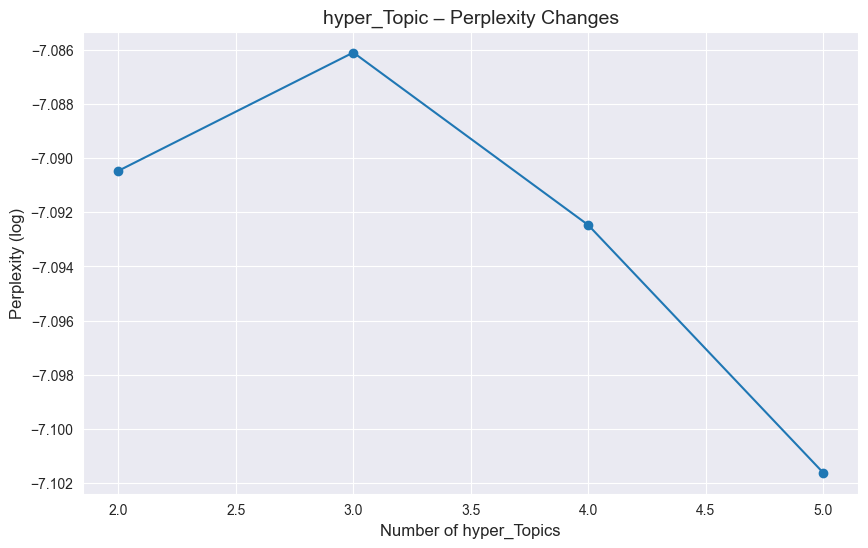

In [73]:
perplexities = []
topic_range = list(range(2, 30))  # 主题数量从 2 到 30

for num_topics in tqdm(topic_range, desc="Evaluating hyper_topics"):
    lda = models.LdaModel(corpus=hyper_corpus, 
                   id2word=hyper_dictionary, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto',
                   per_word_topics=True)
    
    log_perplexity = lda.log_perplexity(hyper_corpus)
    perplexities.append(log_perplexity)

# 画图
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexities, marker='o')
plt.title("hyper_Topic – Perplexity Changes", fontsize=14)
plt.xlabel("Number of hyper_Topics", fontsize=12)
plt.ylabel("Perplexity (log)", fontsize=12)
plt.grid(True)
plt.show()

#### Training

In [74]:
num_topics = 3
# Train LDA
hyper_lda_model = models.LdaModel(corpus=hyper_corpus, 
                   id2word=hyper_dictionary, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto',
                   per_word_topics=True)

In [75]:
hyper_lda_model.print_topics(num_topics, num_words=15)

[(0,
  '0.017*"see" + 0.012*"feel" + 0.011*"imagine" + 0.010*"time" + 0.008*"make" + 0.008*"something" + 0.007*"also" + 0.007*"mind" + 0.007*"head" + 0.007*"even" + 0.007*"could" + 0.007*"try" + 0.007*"one" + 0.006*"dream" + 0.006*"hyperphantasia"'),
 (1,
  '0.016*"mind" + 0.015*"see" + 0.013*"eye" + 0.011*"image" + 0.011*"thought" + 0.009*"imagine" + 0.009*"focus" + 0.008*"apple" + 0.008*"something" + 0.007*"visual" + 0.007*"use" + 0.007*"make" + 0.007*"try" + 0.007*"look" + 0.006*"object"'),
 (2,
  '0.011*"hyperphantasia" + 0.008*"ability" + 0.007*"also" + 0.007*"experience" + 0.007*"brain" + 0.007*"make" + 0.006*"feel" + 0.006*"take" + 0.006*"well" + 0.006*"work" + 0.006*"visualization" + 0.005*"use" + 0.005*"way" + 0.005*"visual" + 0.005*"say"')]

In [76]:
# Visualize Topics
pyLDAvis.enable_notebook()
hyper_vis = pyLDAvis.gensim_models.prepare(hyper_lda_model, hyper_corpus, hyper_dictionary)
pyLDAvis.display(hyper_vis)
# Save to html files
pyLDAvis.save_html(hyper_vis, "hyper_lda_vis_num=3.html")

## BERTopic

### ALL Subreddit

In [102]:
!pip install bertopic
!pip install sentence-transformers

/Users/jinzi/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=12497) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 27.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [bertopic]5/7 [sentence-transformers]


/Users/jinzi/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=12497) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [124]:
print(type(long_docs[0]), long_docs[0])

<class 'list'> ['color', 'pop', 'mind', 'recently', 'interesting', 'moment', 'make', 'could', 'decide', 'color', 'want', 'use', 'abstract', 'painting', 'work', 'husband', 'suggest', 'try', 'something', 'match', 'certain', 'feeling', 'example', 'describe', 'certain', 'situation', 'ask', 'imagine', 'tell', 'color', 'come', 'mind', 'color', 'see', 'somewhere', 'aphant', 'spectrum', 'pop', 'mind', 'see', 'color', 'gut', 'feeling', 'instead', 'brain', 'logical', 'mode', 'guess', 'color', 'theory', 'blue', 'calm', 'red', 'intense', 'yellow', 'energetic', 'way', 'could', 'give', 'situation', 'color', 'feel', 'everyone', 'give', 'color', 'logic', 'want', 'logical', 'choice', 'though', 'guy', 'picture', 'color', 'sense', 'color', 'certain', 'situation', 'curious', 'hear', 'thought', 'experience']


In [73]:
all_texts_bertopic = [" ".join(doc) for doc in long_docs]

In [74]:
print(all_texts_bertopic[0])

color pop mind recently interesting moment make could decide color want use abstract painting work husband suggest try something match certain feeling example describe certain situation ask imagine tell color come mind color see somewhere aphant spectrum pop mind see color gut feeling instead brain logical mode guess color theory blue calm red intense yellow energetic way could give situation color feel everyone give color logic want logical choice though guy picture color sense color certain situation curious hear thought experience


nr_topics=10 -> coherence=0.5369
nr_topics=15 -> coherence=0.4657
nr_topics=20 -> coherence=0.4999
nr_topics=25 -> coherence=0.5304
nr_topics=30 -> coherence=0.5015
nr_topics=50 -> coherence=0.5100
nr_topics=96 -> coherence=0.4946
最佳 nr_topics: 10 coherence: 0.5369216575567218


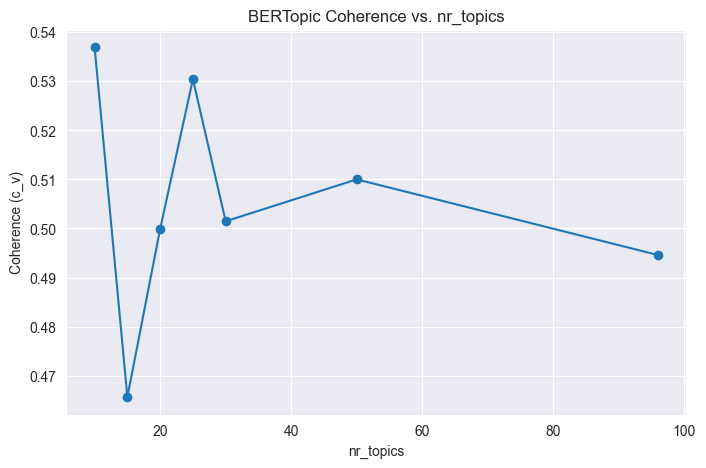

In [146]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# 定义计算 BERTopic coherence 的函数（不分词，直接按空格切分）
def bertopic_coherence(topic_model, texts, top_n=10, metric='c_v'):
    topics_dict = topic_model.get_topics()
    topic_words = [[w for w, _ in topics_dict[k][:top_n]] 
                   for k in topics_dict.keys() if k != -1 and topics_dict[k]]
    tokenized = [t.split() for t in texts]  # 直接按空格切分
    dictionary = Dictionary(tokenized)
    cm = CoherenceModel(topics=topic_words, texts=tokenized, dictionary=dictionary, coherence=metric)
    return cm.get_coherence()

# 假设 texts 已经有数据，这里用 5 个不同的 nr_topics 测试
ks = [10, 15, 20, 25, 30, 50, 96]
scores = []

for k in ks:
    tm = BERTopic(embedding_model = embedding_model, nr_topics=k)
    tm.fit(all_texts_bertopic)  # 直接拟合
    score = bertopic_coherence(tm, all_texts_bertopic, top_n=10, metric='c_v')
    scores.append(score)
    print(f"nr_topics={k} -> coherence={score:.4f}")

best_k = ks[scores.index(max(scores))]
print("最佳 nr_topics:", best_k, "coherence:", max(scores))

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.title("BERTopic Coherence vs. nr_topics")
plt.xlabel("nr_topics")
plt.ylabel("Coherence (c_v)")
plt.grid(True)
plt.show()



In [159]:
from umap import UMAP
from hdbscan import HDBSCAN

# 1. 加载 BERT 嵌入模型
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. 创建 BERTopic 模型（使用默认 UMAP + HDBSCAN 参数）
topic_model = BERTopic(embedding_model=embedding_model)

# 3
topics, probs = topic_model.fit_transform(all_texts_bertopic)

In [165]:
topic_model.visualize_topics()

In [194]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
topic_model.get_topic_info()

Topic  Count  \
0      -1   3649   
1       0    757   
2       1    356   
3       2    315   
4       3    307   
5       4    169   
6       5    158   
7       6    134   
8       7    109   
9       8     83   
10      9     82   
11     10     81   
12     11     77   
13     12     76   
14     13     70   
15     14     69   
16     15     58   
17     16     57   
18     17     57   
19     18     52   
20     19     49   
21     20     47   
22     21     46   
23     22     45   
24     23     42   
25     24     40   
26     25     40   
27     26     39   
28     27     39   
29     28     37   
30     29     37   
31     30     36   
32     31     35   
33     32     35   
34     33     35   
35     34     33   
36     35     32   
37     36     29   
38     37     27   
39     38     27   
40     39     26   
41     40     25   
42     41     25   
43     42     24   
44     43     24   
45     44     24   
46     45     23   
47     46     22   
48     47     21   
49     48     21   
50     49     21   
51     50     20   
52     51     20   
53     52     20   
54     53     20   
55     54     20   
56     55     20   
57     56     19   
58     57     18   
59     58     18   
60     59     18   
61     60     18   
62     61     18   
63     62     17   
64     63     17   
65     64     17   
66     65     17   
67     66     16   
68     67     16   
69     68     16   
70     69     16   
71     70     15   
72     71     15   
73     72     15   
74     73     15   
75     74     15   
76     75     14   
77     76     14   
78     77     14   
79     78     13   
80     79     13   
81     80     13   
82     81     12   
83     82     12   
84     83     12   
85     84     11   
86     85     11   
87     86     11   
88     87     11   
89     88     11   
90     89     11   
91     90     10   

                                                                        Name  \
0                                                   -1_see_feel_mind_imagine   
1                                                    0_voice_hear_word_inner   
2                                                1_read_book_character_story   
3                                                   2_dream_wake_lucid_sleep   
4                                                3_draw_art_artist_reference   
5                                                     4_smell_taste_food_eat   
6                                            5_adhd_autism_autistic_diagnose   
7                                              6_aphantasia_see_aphant_image   
8                                   7_meditation_meditate_breath_mindfulness   
9                                   8_study_participant_research_participate   
10                                                   9_work_learn_well_study   
11                                       10_hyperphantasia_imagine_see_apple   
12                                            11_acquire_aphantasia_dr_cause   
13                                        12_hyperphantasia_bad_anyone_sleep   
14                                     13_photo_relationship_picture_partner   
15                                     14_ptsd_flashback_trauma_dissociation   
16  15_newbie_welcome_httpsaphantasiacomguidehttpsaphantasiacomguide_involve   
17                                              16_psychedelic_lsd_drug_weed   
18                                                 17_screen_focus_scene_eye   
19                      18_voluntary_hallucination_visualization_wakefulness   
20                                         19_math_number_multiplication_add   
21                                                 20_post_claim_fallacy_try   
22                                          21_sdam_memory_episodic_semantic   
23                                                  22_grief_loss_die_grieve   
24                                          23_remember_memory_recall_detail   
25                                           24_see_picture_ima

In [152]:
topic_model.get_topic(6)

[('religion', 0.17039218665219213),
 ('religious', 0.10820932419636523),
 ('god', 0.09724177655419643),
 ('church', 0.07154339621706785),
 ('atheist', 0.051356639607154836),
 ('find', 0.04802729868172429),
 ('christian', 0.04663385407843901),
 ('belief', 0.04243155976557186),
 ('family', 0.0413842858498219),
 ('could', 0.03307599028922613)]

In [153]:
docs_per_topic = topic_model.get_representative_docs()
print(docs_per_topic[6])

['always helpful final thought comment option end survey option space comment end question deconverte xtianity ago option survey accurately record current outlook life sure hypothesis opinion religious belief lack nothing aphantasia religious vague spiritual vaguer satanism religion many recognize one since typically atheistic wicca religion paganism lump abrahamic religion tricky christian bible advocate slavery sex trafficking genocide personally consider moral good value one atheist moral church call religious', 'thought religionreligious experience total aphant grow religious christian household remember even child ashamed embarrassed feel connection god religion ever family member tell story god talk visit never hear kid use pray god cry begging give anything could understand always jealous sibling religious experience relationship god point feel everyone around church lie 20 total aphant could agnostic sort could say religious trauma keep door open try anyway disrespectful debunk

In [164]:
# bar plot
all_topics = list(set(topics))  # 获取所有存在的主题编号
pic_bar = topic_model.visualize_barchart(topics=all_topics)
import plotly.io as pio
pio.show(pic_bar)


### Hyperphantasia

In [139]:
hyper_texts = [" ".join(doc) for doc in clean_hyper_subreddit_docs]
hyper_texts

['method less approximate imagination precise mathematically accurate visualisation often find imagine anything pinpoint exact measurement specific concept eg imagine group object count many item exact distance point b imagine logical mathematical concept imagination conceptual less rigorous however come method help fix imagine cloneagent count calculation manually due time aspect scenario speed slow speed agent also another method counting efficiently imagine space repeatedly group halve object reach imagine group one reverse process fix group size step reach calculate estimate instead guess',
 'imagination obscure actual vision hi sure right place exactly whole spectrum wonder something context early today talk friend average visualization ability visualization sensory information receive lot vivid anyways question imagine visual ever block real life vision ask friend say crazy mind eye versus actual vision look 2 different monitor computer ig focus one time imagine something lose tr

In [140]:
umap_model = UMAP(n_neighbors=25, n_components=5,min_dist=0.3,metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', prediction_data=True)


# 创建 BERTopic 模型
hyper_topic_model = BERTopic(embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       calculate_probabilities=True)

# 拟合文档
hyper_topics, hyper_probs = hyper_topic_model.fit_transform(hyper_texts)

In [141]:
hyper_topic_model.visualize_topics()

In [142]:
hyper_topic_model.get_topic_info()

Topic  Count                              Name  \
0     -1   2525          -1_see_feel_mind_imagine   
1      0    688  0_see_eye_hyperphantasia_imagine   
2      1    145           1_sound_music_hear_mind   
3      2    135           2_dream_wake_lucid_real   
4      3     60      3_memory_remember_recall_see   
5      4     56          4_smell_taste_sense_feel   

                                      Representation  \
0  [see, feel, mind, imagine, make, time, try, al...   
1  [see, eye, hyperphantasia, imagine, mind, imag...   
2  [sound, music, hear, mind, make, head, song, s...   
3  [dream, wake, lucid, real, time, feel, life, s...   
4  [memory, remember, recall, see, something, eve...   
5  [smell, taste, sense, feel, imagine, flavor, e...   

                                 Representative_Docs  
0  [never put test imagine meditation may help co...  
1  [hyperphantasia always see post subreddit desc...  
2  [interesting diverge bit imagine difficult cou...  
3  [everything base personal experience sometimes...  
4  [late 30 early 40 question memory clearly see ...  
5  [activate sense mind first good english well s...

## Diversity


In [103]:
import numpy as np

# —— 共用：按 Top-K 词计算 Diversity —— 
def topic_diversity_from_topic_words(topic_words, top_k=10):
    topic_words = [tw[:top_k] for tw in topic_words if len(tw) > 0]
    if not topic_words:
        return 0.0, []
    flat = [w for tw in topic_words for w in tw]
    overall = len(set(flat)) / (len(topic_words) * top_k)  # 经典定义
    per_topic_unique = [len(set(tw)) / max(1, len(tw)) for tw in topic_words]
    return overall, per_topic_unique

def jaccard_diversity(topic_words, top_k=10):
    sets_ = [set(tw[:top_k]) for tw in topic_words if len(tw) > 0]
    n = len(sets_)
    if n < 2:
        return 0.0
    vals = []
    for i in range(n):
        for j in range(i+1, n):
            inter = len(sets_[i] & sets_[j]); uni = len(sets_[i] | sets_[j])
            jacc = inter / uni if uni > 0 else 0.0
            vals.append(1.0 - jacc)  # 越大越分散
    return float(np.mean(vals)) if vals else 0.0

# —— 从 BERTopic 提取 Top-K 词 —— 
def get_topic_words_from_bertopic(topic_model, top_k=10, include_outlier=False):
    topics_dict = topic_model.get_topics()
    topic_ids = sorted([t for t in topics_dict.keys() if include_outlier or t != -1])
    topic_words = []
    for tid in topic_ids:
        pairs = topics_dict.get(tid, [])
        topic_words.append([w for w, _ in pairs[:top_k]])
    return topic_words

# —— 从 gensim LDA 提取 Top-K 词 —— 
def get_topic_words_from_gensim_lda(lda_model, top_k=10):
    topics = lda_model.show_topics(num_topics=-1, num_words=top_k, formatted=False)
    topics = sorted(topics, key=lambda x: x[0])
    return [[w for w, _ in pairs] for _, pairs in topics]

# —— 一键评估 —— 
def evaluate_diversity_for_bertopic(topic_model, top_k=10, include_outlier=False):
    tw = get_topic_words_from_bertopic(topic_model, top_k=top_k, include_outlier=include_outlier)
    overall, per_topic = topic_diversity_from_topic_words(tw, top_k=top_k)
    jdiv = jaccard_diversity(tw, top_k=top_k)
    return {
        "overall_diversity": overall,
        "mean_per_topic_unique": float(np.mean(per_topic)) if per_topic else 0.0,
        "jaccard_diversity": jdiv
    }

def evaluate_diversity_for_lda(lda_model, top_k=10):
    tw = get_topic_words_from_gensim_lda(lda_model, top_k=top_k)
    overall, per_topic = topic_diversity_from_topic_words(tw, top_k=top_k)
    jdiv = jaccard_diversity(tw, top_k=top_k)
    return {
        "overall_diversity": overall,
        "mean_per_topic_unique": float(np.mean(per_topic)) if per_topic else 0.0,
        "jaccard_diversity": jdiv
    }


In [104]:
TOP_K = 10  # 常用10或20

# LDA
lda_div = evaluate_diversity_for_lda(lda_model, top_k=TOP_K)
print("LDA diversity:", lda_div)

# BERTopic（默认不包含-1离群主题）
bertopic_div = evaluate_diversity_for_bertopic(topic_model, top_k=TOP_K, include_outlier=False)
print("BERTopic diversity:", bertopic_div)


LDA diversity: {'overall_diversity': 0.6904761904761905, 'mean_per_topic_unique': 1.0, 'jaccard_diversity': 0.9698854980588728}
BERTopic diversity: {'overall_diversity': 0.8421052631578947, 'mean_per_topic_unique': 1.0, 'jaccard_diversity': 0.9856185010169043}


# Sentiment Analysis

## ALL

In [10]:
from transformers import pipeline

/Users/jinzi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# 先筛选：词数小于300的评论
filtered_df = comments_df[comments_df["comment_body"].notna() & 
                          (comments_df["comment_body"].str.split().apply(len) < 300)]

# 然后再从中抽样200条
sample_texts = filtered_df.sample(200, random_state=42)["comment_body"].tolist()
sentiment_sample_df = pd.DataFrame({"text": sample_texts})
sentiment_sample_df["label"] = ""
sentiment_sample_df.to_csv("sentiment_samples_to_label.csv", index=False)

In [36]:
labeled_sample_sentiment = pd.read_csv("sentiment_samples_to_label.csv", encoding="ISO-8859-1")

In [37]:
labeled_sample_sentiment

text     label
0    I subconsciously block bad taste, I do taste v...   neutral
1    Man its so frustrating how much depth can exis...  negative
2    The best preparation for me is to write up not...  positive
3    Cool! Glad you found your niche. Im like that ...  positive
4    It__ so hard to explain. I__e been working on ...   neutral
..                                                 ...       ...
195  I guess my husband always knew, he would say _...  positive
196  Haha same girl same! \n\nLots of Google Photos...  positive
197  I get intense open eye visuals on acid and mus...   neutral
198  Wait, is it? I thought synesthesia was just li...   neutral
199  Unrelated to the post, but maybe try the podca...   neutral

[200 rows x 2 columns]

### RoBERTa

load the model

In [197]:
# 加载 HuggingFace 上的 RoBERTa 情感分析模型
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    truncation=True,
    max_length=512
)

In [33]:
comments_df["comment_body"]

0        I know sky-blue is my favorite color. Other th...
1        I can "feel" colors. \n\nI knew, for example, ...
2        I get a sense of colors but it’s not visual. L...
3        I can feel colours with other people, but not ...
4        I think I know exactly what you mean! I mostly...
                               ...                        
22878    Kinda, yeah. Maybe I don’t understand subvocal...
22879    I think I can activate verbal thought in my he...
22880    Theres different ways of using your vocal chor...
22881    Yeah. I just use my vocal chords most of the t...
22882    Yeah, Im also AuDHD, so totally get you. I don...
Name: comment_body, Length: 22883, dtype: object

test

In [198]:
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [199]:
texts = labeled_sample_sentiment["text"].tolist()
true_labels = labeled_sample_sentiment["label"].tolist()

In [200]:
roberta_results = sentiment_pipeline(texts)
pred_labels = [label_map[res["label"]] for res in roberta_results]

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; us

KeyboardInterrupt: 

In [46]:
labeled_sample_sentiment["roberta_label"] = pred_labels

In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report


# 计算指标
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="macro")
recall = recall_score(true_labels, pred_labels, average="macro")
f1 = f1_score(true_labels, pred_labels, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels))

Accuracy: 0.6200
Precision (macro): 0.5834
Recall (macro): 0.6653
F1 Score (macro): 0.5788

Classification Report:

              precision    recall  f1-score   support

    negative       0.29      0.80      0.42        20
     neutral       0.78      0.60      0.68       126
    positive       0.68      0.59      0.63        54

    accuracy                           0.62       200
   macro avg       0.58      0.67      0.58       200
weighted avg       0.71      0.62      0.64       200



In [49]:
labeled_sample_sentiment

text     label roberta_label
0    I subconsciously block bad taste, I do taste v...   neutral      negative
1    Man its so frustrating how much depth can exis...  negative      negative
2    The best preparation for me is to write up not...  positive      positive
3    Cool! Glad you found your niche. Im like that ...  positive      positive
4    It__ so hard to explain. I__e been working on ...   neutral       neutral
..                                                 ...       ...           ...
195  I guess my husband always knew, he would say _...  positive       neutral
196  Haha same girl same! \n\nLots of Google Photos...  positive      positive
197  I get intense open eye visuals on acid and mus...   neutral      negative
198  Wait, is it? I thought synesthesia was just li...   neutral       neutral
199  Unrelated to the post, but maybe try the podca...   neutral      positive

[200 rows x 3 columns]

apply

In [201]:
batch_size = 100
roberta_sentiments = []
roberta_scores = []
total_comment_texts = comments_df["comment_body"].tolist()

for i in tqdm(range(0, len(total_comment_texts), batch_size), desc="Processing Sentiment"):
    batch = total_comment_texts[i:i+batch_size]
    try:
        result = sentiment_pipeline(batch)
        roberta_sentiments += [r["label"] for r in result]
        roberta_scores += [r["score"] for r in result]
    except Exception as e:
        print(f"Batch {i}-{i+batch_size} failed: {e}")
        roberta_sentiments += ["ERROR"] * len(batch)
        roberta_scores += [0.0] * len(batch)


Processing Sentiment: 100%|██████████| 229/229 [16:34<00:00,  4.34s/it]


In [202]:
comments_df["roberta_label"] = roberta_sentiments
comments_df["roberta_score"] = roberta_scores

In [203]:
label_map = {"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive"}
comments_df["roberta_label"] = comments_df["roberta_label"].map(label_map)

In [143]:
print(comments_df.head())

  comment_id  post_id   subreddit        comment_author    comment_timestamp  \
0    n0mrot0  1logpyp  Aphantasia          SonOfMrSpock  2025-06-30 20:34:17   
1    n0mt3za  1logpyp  Aphantasia             majandess  2025-06-30 20:41:29   
2    n0opsuu  1logpyp  Aphantasia  Miserable_Smoke_6719  2025-07-01 02:50:13   
3    n0mu4yk  1logpyp  Aphantasia   FlightOfTheDiscords  2025-06-30 20:46:36   
4    n0qceis  1logpyp  Aphantasia     Haunting_Pear8052  2025-07-01 10:47:50   

                                        comment_body  comment_score  depth  \
0  I know sky-blue is my favorite color. Other th...              6      0   
1  I can "feel" colors. \n\nI knew, for example, ...              7      0   
2  I get a sense of colors but it’s not visual. L...              4      0   
3  I can feel colours with other people, but not ...              2      0   
4  I think I know exactly what you mean! I mostly...              2      0   

   is_top_level parent_id  ...  \
0             1 

In [204]:
def calc_polarity(label, score):
    if label == "positive":
        return score
    elif label == "negative":
        return -score
    else:  # neutral
        return 0.0

comments_df["roberta_polarity"] = [
    calc_polarity(lab, sc) for lab, sc in zip(comments_df["roberta_label"], comments_df["roberta_score"])
]

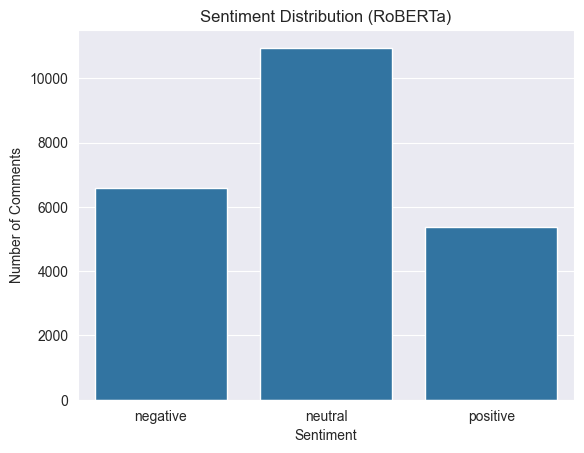

In [205]:
# 柱状图统计情绪分布
sns.countplot(data=comments_df, x="roberta_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (RoBERTa)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

### VADER

In [51]:
!pip install vaderSentiment

In [207]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [206]:
analyzer = SentimentIntensityAnalyzer()

test

In [208]:
def vader_label_from_text(text, pos_th=0.05, neg_th=-0.05):
    c = analyzer.polarity_scores(str(text))['compound']
    if c >= pos_th:
        return 'positive', c
    elif c <= neg_th:
        return 'negative', c
    else:
        return 'neutral', c
# 预测并回填到 DataFrame
v_labels, v_compounds = zip(*[vader_label_from_text(t) for t in texts])
labeled_sample_sentiment["vader_label"] = list(v_labels)
labeled_sample_sentiment["vader_compound"] = list(v_compounds)

# 计算指标（宏平均）
v_accuracy = accuracy_score(true_labels, v_labels)
v_precision = precision_score(true_labels, v_labels, average="macro")
v_recall = recall_score(true_labels, v_labels, average="macro")
v_f1 = f1_score(true_labels, v_labels, average="macro")

print(f"[VADER] Accuracy: {v_accuracy:.4f}")
print(f"[VADER] Precision (macro): {v_precision:.4f}")
print(f"[VADER] Recall (macro): {v_recall:.4f}")
print(f"[VADER] F1 Score (macro): {v_f1:.4f}\n")
print("[VADER] Classification Report:\n")
print(classification_report(true_labels, v_labels))

[VADER] Accuracy: 0.4550
[VADER] Precision (macro): 0.5125
[VADER] Recall (macro): 0.6063
[VADER] F1 Score (macro): 0.4571

[VADER] Classification Report:

              precision    recall  f1-score   support

    negative       0.34      0.75      0.47        20
     neutral       0.82      0.25      0.39       126
    positive       0.38      0.81      0.51        54

    accuracy                           0.46       200
   macro avg       0.51      0.61      0.46       200
weighted avg       0.65      0.46      0.43       200



In [114]:
labeled_sample_sentiment

text     label  \
0    I subconsciously block bad taste, I do taste v...   neutral   
1    Man its so frustrating how much depth can exis...  negative   
2    The best preparation for me is to write up not...  positive   
3    Cool! Glad you found your niche. Im like that ...  positive   
4    It__ so hard to explain. I__e been working on ...   neutral   
..                                                 ...       ...   
195  I guess my husband always knew, he would say _...  positive   
196  Haha same girl same! \n\nLots of Google Photos...  positive   
197  I get intense open eye visuals on acid and mus...   neutral   
198  Wait, is it? I thought synesthesia was just li...   neutral   
199  Unrelated to the post, but maybe try the podca...   neutral   

    roberta_label vader_label  vader_compound  
0        negative    negative         -0.2815  
1        negative    negative         -0.5777  
2        positive    positive          0.9186  
3        positive    positive          0.8775  
4         neutral    positive          0.9640  
..            ...         ...             ...  
195       neutral    positive          0.9194  
196      positive    positive          0.8619  
197      negative    negative         -0.6124  
198       neutral    positive          0.4329  
199      positive     neutral          0.0000  

[200 rows x 5 columns]

In [209]:
def get_vader_scores(text):
    vader_scores = analyzer.polarity_scores(text)
    return pd.Series([vader_scores["compound"], vader_scores["pos"], vader_scores["neu"], vader_scores["neg"]])

In [210]:
comments_df[["vader_compound", "vader_pos", "vader_neu", "vader_neg"]] = comments_df["comment_body"].apply(get_vader_scores)

In [211]:
def vader_label(vader_scores):
    if vader_scores >= 0.05:
        return "positive"
    elif vader_scores <= -0.05:
        return "negative"
    else:
        return "neutral"

comments_df["vader_label"] = comments_df["vader_compound"].apply(vader_label)

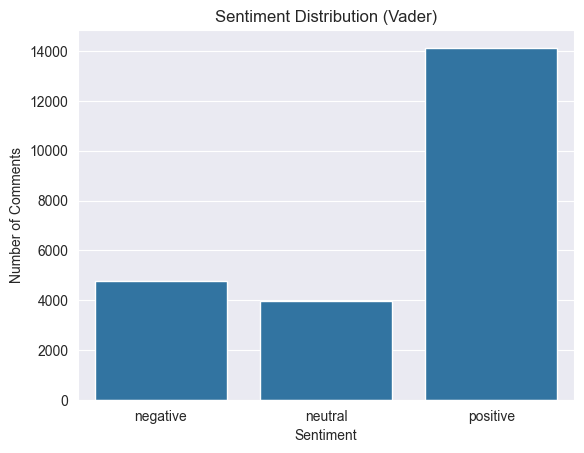

In [212]:
sns.countplot(data=comments_df, x="vader_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (Vader)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

In [213]:
# 对 comment_body 每条文本算 VADER polarity
comments_df["vader_polarity"] = comments_df["comment_body"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)

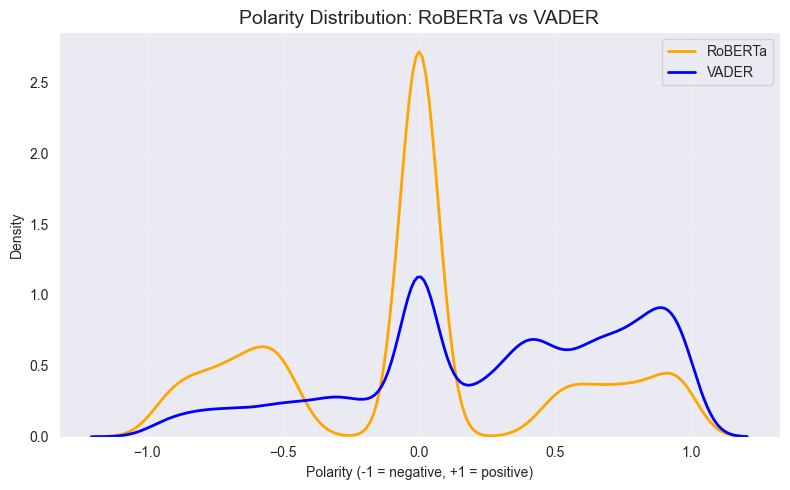

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.kdeplot(comments_df["roberta_polarity"], label="RoBERTa", color="orange", linewidth=2)
sns.kdeplot(comments_df["vader_polarity"],   label="VADER",   color="blue", linewidth=2)

plt.title("Polarity Distribution: RoBERTa vs VADER", fontsize=14)
plt.xlabel("Polarity (-1 = negative, +1 = positive)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [113]:
comments_df[["comment_body", "vader_label", "roberta_label"]].head(10)

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead



KeyError: "['roberta_label'] not in index"

In [61]:
disagree_df = comments_df[
    (comments_df["roberta_label"] == "positive") & 
    (comments_df["vader_label"] == "negative")
]

disagree_df[["comment_body", "sentiment_score", "vader_compound"]].head()


comment_body  sentiment_score  \
11   Oh that's interesting! Not sure I could do tha...         0.499154   
41   I definitely think my aphantasia and related S...         0.647241   
76         The white and blue coke can goes hard ngl 🔥         0.623408   
117  Very cool.  If I block out most of the surroun...         0.839056   
184  there is no red in the image and i can see red...         0.791229   

     vader_compound  
11          -0.3927  
41          -0.0772  
76          -0.4215  
117         -0.3626  
184         -0.1027

In [214]:
# 筛选一致的样本
agreed_df = comments_df[comments_df["roberta_label"] == comments_df["vader_label"]].copy()

In [215]:
top_5_df = agreed_df.sort_values("vader_compound", ascending=False).head(int(len(agreed_df) * 0.05))
bottom_5_df = agreed_df.sort_values("vader_compound", ascending=True).head(int(len(agreed_df) * 0.05))

In [74]:
top_5_df

comment_id  post_id       subreddit        comment_author  \
8885     mnpka7g  1jyjdi9      Aphantasia              Sans-Foy   
21264    iy3oicg   z5577g  Hyperphantasia     DilatedPoreOfLara   
5467     mrhalq3  1ki7hmg      Aphantasia              buddy843   
4517     mssq88i  1kom35j      Aphantasia              buddy843   
1444     mxxtcy1  1lbo5qp      Aphantasia              buddy843   
...          ...      ...             ...                   ...   
7172     mohmptd  1k5bora      Aphantasia          Known-Ad-100   
11959    mhczuzh  1j9cd1o      Aphantasia           Pokenerd182   
18023    k9676ga  17uu1fu  Hyperphantasia           Stahlmensch   
19739    msyrd0v  12upgtw  Hyperphantasia  AcanthopterygiiNo340   
4910     mrxz6xw  1kkgymv      Aphantasia  Remarkable_Trust5745   

         comment_timestamp                                       comment_body  \
8885   2025-04-18 05:42:02  This is really fascinating in the sense it eve...   
21264  2022-11-28 14:48:09  I don't have synesthesia, but I am so curious ...   
5467   2025-05-09 21:32:37  Also thought you could use my list of top ten ...   
4517   2025-05-17 15:26:13  My personal TOP TEN aphant positives\n\nMy lis...   
1444   2025-06-15 18:19:53  My personal TOP TEN aphant positives\n\nMy lis...   
...                    ...                                                ...   
7172   2025-04-22 21:05:45  My dreams are very visual, even though I can't...   
11959  2025-03-12 10:10:57  I'm exactly the same with not remembering deta...   
18023  2023-11-14 04:34:41  Currently, I have tried masturbating, taking a...   
19739  2025-05-18 16:10:36  Dude same exact scenario…just in reverse. I ju...   
4910   2025-05-12 18:09:02  So if i am understanding you used to be able t...   

       comment_score  depth  is_top_level parent_id  ... sentiment_score  \
8885               1      1             0   mmz4532  ...        0.671374   
21264              2      1             0   ixwbe6f  ...        0.878022   
5467               1      1             0   mrh9z71  ...        0.628238   
4517              50      0             1   1kom35j  ...        0.692739   
1444               4      0             1   1lbo5qp  ...        0.688757   
...              ...    ...           ...       ...  ...             ...   
7172               2      0             1   1k5bora  ...        0.616757   
11959              2      0             1   1j9cd1o  ...        0.589252   
18023              2      1             0   k96615j  ...        0.923687   
19739              1      5             0   mq0z208  ...        0.675270   
4910               5      0             1   1kkgymv  ...        0.506128   

                                     comment_text_tokens token_count  \
8885   [really, fascinating, sense, even, explain, wa...         394   
21264  [do, not, synesthesia, curious, love, way, des...         114   
5467   [also, think, could, use, list, top, ten, posi...         339   
4517   [personal, top, ten, aphant, positive, list, m...         325   
1444   [personal, top, ten, aphant, positive, list, m...         328   
...                                                  ...         ...   
7172   [dream, visual, even, though, can, not, visual...          37   
11959  [I, m, exactly, remember, detail, people, yest...          93   
18023  [currently, try, masturbate, take, shower, dri...          31   
19739  [dude, exact, scenariojust, reverse, stumble, ...          73   
4910   [understanding, use, able, visualize, imagine,...         139   

       vader_compound vader_pos  vader_neu  vader_neg  vader_label  \
8885           0.9989     0.168      0.820      0.012     positive   
21264          0.9988     0.338      0.644      0.018     positive   
5467           0.9987     0.167      0.789      0.044     positive   
4517           0.9986     0.165      0.790      0.045     positive   
1444           0.9986     0.162      0.794      0.044     positive   
...               ...       ..

In [73]:
bottom_5_df

comment_id  post_id       subreddit        comment_author  \
17077    kse95s1  1axz0ej  Hyperphantasia  EstablishmentWhich82   
5224     mrh5xn0  1kiqmle      Aphantasia           OneIdentity   
37       n0mi9za  1lod57d      Aphantasia               Kappy01   
22832    l9q7yrt  195umw7     silentminds             BarNo3385   
9654     mm21ef0  1jtvi2f      Aphantasia    sporadic_beethoven   
...          ...      ...             ...                   ...   
590      mzv6to2  1lkra3n      Aphantasia             nacnud_uk   
1504     mxxqycn  1lbo5qp      Aphantasia  Significant-Panda-53   
9384     mmlsali  1jvjwq2      Aphantasia    Zestyclose-Ad-7576   
12560    mu1ovu2  1kthkgr  Hyperphantasia       lavenderlemon11   
5342     mrffkw2  1kidzkn      Aphantasia       OhTheHueManatee   

         comment_timestamp                                       comment_body  \
17077  2024-02-27 16:35:14  (Sorry this is long!)\n\nIt's the circular thi...   
5224   2025-05-09 21:08:42  Aphantasia gets blamed for a ton of problems t...   
37     2025-06-30 19:48:51  Some folks have theorized about it. My suggest...   
22832  2024-06-22 07:00:12  Not had a lot of experience, but I hated it.\n...   
9654   2025-04-08 17:16:39  Me and my girlfriend were both traumatized as ...   
...                    ...                                                ...   
590    2025-06-26 12:41:34  Are you implying that blind people have no spa...   
1504   2025-06-15 18:07:49  audio and other sense counts as imagery, it do...   
9384   2025-04-11 19:19:45  I didn’t know I was unusual until about a year...   
12560  2025-05-24 19:14:49  This! Haha! Like ok yes I am constantly aware ...   
5342   2025-05-09 15:52:08  I'm way better at remembering concepts than I ...   

       comment_score  depth  is_top_level parent_id  ... sentiment_score  \
17077              1      4             0   ks2c5b7  ...        0.707167   
5224              38      0             1   1kiqmle  ...        0.901202   
37                 1      0             1   1lod57d  ...        0.744729   
22832              1      0             1   195umw7  ...        0.759648   
9654               1      3             0   mlxc5pm  ...        0.910384   
...              ...    ...           ...       ...  ...             ...   
590                2      0             1   1lkra3n  ...        0.877568   
1504               0      3             0   mxwzyrs  ...        0.511596   
9384               2      0             1   1jvjwq2  ...        0.763850   
12560              3      1             0   mu0zzcq  ...        0.785900   
5342               1      0             1   1kidzkn  ...        0.525544   

                                     comment_text_tokens token_count  \
17077  [sorry, long, circular, thing, ever, nightmare...         679   
5224   [aphantasia, get, blame, ton, problem, unrelat...          72   
37     [folk, theorize, suggestion, will, not, visual...         132   
22832  [lot, experience, hate, compare, alcohol, drin...         107   
9654   [girlfriend, traumatize, child, able, visualiz...          48   
...                                                  ...         ...   
590    [imply, blind, people, spatial, awareness, you...           8   
1504   [audio, sense, count, imagery, do, not, apply,...          34   
9384   [do, not, know, unusual, year, ago, work, guy,...          70   
12560  [haha, like, ok, yes, constantly, aware, alert...          18   
5342   [I, m, way, well, remembering, concept, name, ...          50   

       vader_compound vader_pos  vader_neu  vader_neg  vader_label  \
17077         -0.9981     0.057      0.827      0.116     negative   
5224          -0.9960     0.034      0.614      0.352     negative   
37            -0.9953     0.059      0.725      0.216     negative   
22832         -0.9934     0.016      0.787      0.197     negative   
9654          -0.9928     0.023      0.640      0.337     negative   
...               ...       ..

In [216]:
custom_stopwords = {"t", "ve", "re", "d", "m", "ll", "s", "I",
                    "also", "would", "think", "people", "get", "go", "like", "just", "know", "thing", "things", "really"}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

In [218]:
from sklearn.feature_extraction.text import CountVectorizer

In [219]:
# 2. 对子集分别进行 stopwords 清洗
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

top_5_df["text_clean"] = top_5_df["comment_body"].apply(remove_stopwords)
bottom_5_df["text_clean"] = bottom_5_df["comment_body"].apply(remove_stopwords)

# 3. 用 clean 文本建 BERTopic
top_texts = top_5_df["text_clean"].dropna().tolist()
bottom_texts = bottom_5_df["text_clean"].dropna().tolist()

# 构造 vectorizer（再传入 BERTopic）
vectorizer_model = CountVectorizer(stop_words='english')
topic_model_top = BERTopic(vectorizer_model=vectorizer_model)
topic_model_bottom = BERTopic(vectorizer_model=vectorizer_model)

# 主题建模
topics_top, _ = topic_model_top.fit_transform(top_texts)
topics_bottom, _ = topic_model_bottom.fit_transform(bottom_texts)



In [220]:
# 可视化
top_vis = topic_model_top.visualize_topics()
top_vis

In [221]:
topic_model_top.get_topic_info()

Topic  Count                                    Name  \
0      -1    231                     -1_im_time_ive_mind   
1       0     41                    0_apple_im_way_image   
2       1     41  1_aphantasia_feel_different_successful   
3       2     32            2_draw_art_drawing_reference   
4       3     30            3_pictures_house_photos_love   
5       4     27           4_dreams_dream_lucid_remember   
6       5     26               5_read_reading_books_book   
7       6     23               6_music_hear_play_playing   
8       7     23  7_hyperphantasia_study_research_thanks   
9       8     21            8_try_want_visulization_mind   
10      9     20                   9_life_love_mind_good   
11     10     20              10_smell_taste_touch_sense   
12     11     10             11_hands_sport_feel_imagine   

                                                                                        Representation  \
0                                       [im, time, ive, mind, memory, feel, good, life, remember, way]   
1                                   [apple, im, way, image, eyes, mind, ive, imagined, imagine, scene]   
2                     [aphantasia, feel, different, successful, helped, aphant, im, sdam, tell, learn]   
3                              [draw, art, drawing, reference, want, create, make, work, look, artist]   
4                         [pictures, house, photos, love, memories, relationship, lot, im, face, feel]   
5                        [dreams, dream, lucid, remember, dreaming, wake, vivid, ive, im, interesting]   
6                          [read, reading, books, book, movies, series, description, love, im, novels]   
7                   [music, hear, play, playing, song, instrument, head, instruments, body, listening]   
8   [hyperphantasia, study, research, thanks, objects, interesting, participation, hi, link, insights]   
9                        [try, want, visulization, mind, im, focus, help, thoughts, min, prophantasia]   
10                                    [life, love, mind, good, feel, way, dont, say, want, experience]   
11                    [smell, taste, touch, sense, flavors, olfactory, feel, excellent, smells, foods]   
12                              [hands, sport, feel, imagine, stim, yes, sports, motions, keys, limbs]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [222]:
bottom_vis = topic_model_bottom.visualize_topics()
bottom_vis

In [224]:
topic_model_bottom.get_topic_info()

Topic  Count                                  Name  \
0      -1    259            -1_im_time_feel_aphantasia   
1       0     57             0_ptsd_trauma_remember_im   
2       1     53           1_horror_fear_movies_scared   
3       2     45             2_im_look_drawing_picture   
4       3     28  3_aphantasia_acquired_memory_imagery   
5       4     26                4_thoughts_mind_try_im   
6       5     21              5_music_sound_voice_head   
7       6     19        6_psychedelics_drunk_thats_bad   
8       7     13            7_brain_make_behavior_post   
9       8     13              8_time_im_adhd_basically   
10      9     11   9_disgusting_disgusted_disgust_fine   

                                                                                                 Representation  \
0                                           [im, time, feel, aphantasia, life, head, way, mind, words, imagine]   
1                               [ptsd, trauma, remember, im, grief, autism, aphantasia, flashbacks, died, time]   
2                                   [horror, fear, movies, scared, scary, im, dream, sleep, dreams, nightmares]   
3                                       [im, look, drawing, picture, draw, imagine, object, visual, ive, wrong]   
4                        [aphantasia, acquired, memory, imagery, adhd, aphants, likely, trauma, hyper, believe]   
5                                     [thoughts, mind, try, im, inner, repress, thought, words, thinking, head]   
6                                     [music, sound, voice, head, hear, tune, tinnitus, couple, noise, imagine]   
7   [psychedelics, drunk, thats, bad, alcohol, antipsychotics, hyperphantasia, experience, dose, hyperfantasia]   
8                                        [brain, make, behavior, post, trying, logic, basic, ill, use, illness]   
9                                   [time, im, adhd, basically, tired, hours, lost, computer, kindve, struggle]   
10                        [disgusting, disgusted, disgust, fine, word, mongrel, frown, ugh, piss, embarrassing]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [1]:
topic_model_bottom.representative_docs_(2)

NameError: name 'topic_model_bottom' is not defined

## Non-aphantasia VS Aphantasia

In [185]:
!pip install sentence-transformers scikit-learn

In [11]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer("all-MiniLM-L6-v2")

semantic_queries = [
    "I didn't know aphantasia existed",
    "I can't imagine not having mental images",
    "That’s crazy you can’t see pictures in your head",
    "I always thought everyone could visualize",
    "It’s fascinating that some people can’t imagine things",
    "I feel bad for people who can't picture things",
]

comments_texts = comments_df["comment_body"].fillna("").tolist()
# 3. 文本嵌入
comment_embeddings = model.encode(comments_texts, convert_to_tensor=True)
query_embeddings = model.encode(semantic_queries, convert_to_tensor=True)

# 4. 计算相似度
similarities = cosine_similarity(query_embeddings.cpu().numpy(), comment_embeddings.cpu().numpy())


/Users/jinzi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import numpy as np
# 5. 获取最相似的 top-N
top_n = 30  # 你想看前30个最相关的

# 为每个 query 提取 top_n
top_matches = []
for i, sim_scores in enumerate(similarities):
    top_indices = np.argsort(sim_scores)[::-1][:top_n]
    for idx in top_indices:
        top_matches.append({
            "query": semantic_queries[i],
            "score": sim_scores[idx],
            "comments_texts": comments_texts[idx]
        })

# 转为 DataFrame 方便查看
import pandas as pd
top_matches_df = pd.DataFrame(top_matches).sort_values(by="score", ascending=False).drop_duplicates("comments_texts")


In [21]:
top_matches_df[["comments_texts"]]

comments_texts
0           I don’t think you know what aphantasia is.
1               That's great, but it's not aphantasia.
2              Aphantasia? I don't really care I guess
3     OK. But this isn't related to aphantasia at all.
4    I don’t think this has anything to do with aph...
..                                                 ...
175  Like many of us aphants I was amazed that peop...
176  100%\nSame goes for seeing disturbing images, ...
177  >These bother me:  \n>  \n>1. Do other people ...
178  *”when i try to visualize something i just see...
179  Sorry about formatting. On mobile.\nI’m not qu...

[173 rows x 1 columns]

In [22]:
texts_for_goemotions = top_matches_df["comments_texts"].dropna().tolist()

In [23]:
texts_for_goemotions 

['I don’t think you know what aphantasia is.',
 "That's great, but it's not aphantasia.",
 "Aphantasia? I don't really care I guess",
 "OK. But this isn't related to aphantasia at all.",
 'I don’t think this has anything to do with aphantasia.',
 "It's not aphantasia, just very close to it.",
 'I don’t want to have to start explaining Aphantasia and thought it would be easier to ask here',
 "I don't think your issue is with aphantasia.",
 'I do not think this is an aphantasia thing',
 'I had no idea this was a thing even after knowing I had aphantasia 😂',
 "Aphantasia kinda sucks tbh, I'm jealous too",
 "Aphantasia here, I don't see shit in my head",
 'Yes, that is what aphantasia is.',
 'What is Aphantasia 1?',
 "Most PPL just don't believe aphantasia is a thing.",
 'Yes, definitely aphantasia. Welcome.',
 'Thank you again, you seem to have quite a bit of knowledge on aphantasia.',
 'This is exactly how I realized I had a aphantasia',
 "https://i.redd.it/dt1zq3a075ue1.gif\n\nBro goes 

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import sigmoid

# 模型 & 标签（你已有）
model = AutoModelForSequenceClassification.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
tokenizer = AutoTokenizer.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
          'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization',
          'relief', 'remorse', 'sadness', 'surprise']

In [25]:
# 文本
inputs = tokenizer(texts_for_goemotions , padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
probs = sigmoid(logits)

In [30]:
# 阈值
threshold = 0.7
emotion_results = []
for i, prob in enumerate(probs):
    emotions = [labels[j] for j, p in enumerate(prob) if p > threshold]
    emotion_results.append({
        "text": texts_for_goemotions[i],
        "emotions": emotions
    })

In [31]:
emotion_df = pd.DataFrame(emotion_results)

In [32]:
emotion_df

text  \
0           I don’t think you know what aphantasia is.   
1               That's great, but it's not aphantasia.   
2              Aphantasia? I don't really care I guess   
3     OK. But this isn't related to aphantasia at all.   
4    I don’t think this has anything to do with aph...   
..                                                 ...   
168  Like many of us aphants I was amazed that peop...   
169  100%\nSame goes for seeing disturbing images, ...   
170  >These bother me:  \n>  \n>1. Do other people ...   
171  *”when i try to visualize something i just see...   
172  Sorry about formatting. On mobile.\nI’m not qu...   

                                              emotions  
0                                          [confusion]  
1                                           [surprise]  
2                               [confusion, curiosity]  
3                                [confusion, surprise]  
4                                [confusion, surprise]  
..                                                 ...  
168    [annoyance, confusion, disappointment, sadness]  
169                                   [disgust, pride]  
170             [annoyance, confusion, disappointment]  
171  [caring, confusion, curiosity, realization, su...  
172                                [caring, confusion]  

[173 rows x 2 columns]

In [34]:
# 展平所有标签为一个 list
all_emotions = [emotion for sublist in emotion_df['emotions'] for emotion in sublist]

# 统计每个情绪的频率
emotion_counts = Counter(all_emotions)
emotion_series = pd.Series(emotion_counts).sort_values(ascending=False)


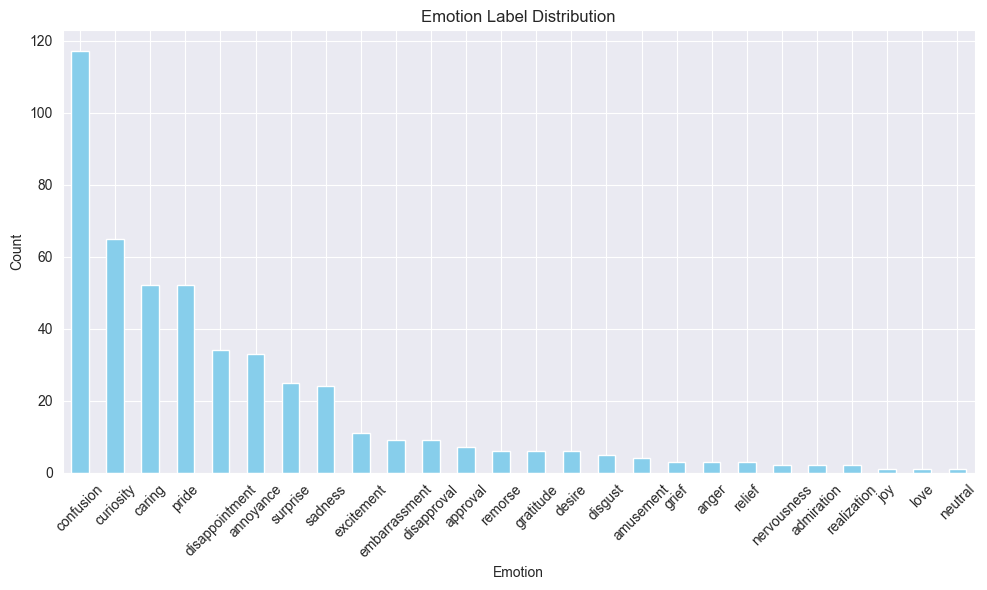

In [35]:
plt.figure(figsize=(10, 6))
emotion_series.plot(kind="bar", color="skyblue")
plt.title("Emotion Label Distribution")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Neurodiversity

keyword

In [96]:
neuro_keywords = [
    "autism", "asd", "adhd", "add", "ptsd", "ocd",
    "neurodiverse", "neurodiversity", "trauma", "sdam",
    "dyslexia", "bipolar", "anxiety", "depression",
    "executive dysfunction", "flashback", "hyperfixation"
]

In [97]:
post_nd_df = posts_df[
    posts_df["post_text"].str.contains("|".join(neuro_keywords), case=False, na=False)
]
comment_nd_df = comments_df[
    comments_df["comment_body"].str.contains("|".join(neuro_keywords), case=False, na=False)
]

In [98]:
post_nd_df

subreddit  post_id                                         post_title  \
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
6      Aphantasia  1lnwyvg                                               Sad.   
11     Aphantasia  1ln4pj9               New here, got questions, please help   
14     Aphantasia  1lmqw0k               Lack of sounds and “inner monologue”   
18     Aphantasia  1llt6mx  Imagining a better life for yourself with apha...   
...           ...      ...                                                ...   
1573  silentminds  1f19ecn                    Anendophasia but not Anauralia?   
1576  silentminds  1evzwy8                   Reading and general confusion...   
1584  silentminds  1dw18ma                               Is this silent mind?   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   

                                              post_body           post_author  \
2                                             Thoughts?       Sobergirlaudrey   
6     I am44 and spent most of my life knowing somet...       thecooldude2025   
11    Hey there, found out about a year ago that aph...        JefftheHognose   
14    So I'm realizing that my brain is even more od...  KingCroissantCrawler   
18    So, I have aphantasia and I definitely struggl...      Plane_Excuse1804   
...                                                 ...                   ...   
1573  Okay, so in the last 2 days I have realised th...            stereobobi   
1576  Hi all,\n\nI'm not entirely sure I'm in the ri...           StevenSamAI   
1584  I’m a multi sensory aphant, I can’t imagine vi...               deleted   
1609  Freud's Three Levels of Mind, and many other m...               NITSIRK   
1611  Instead of mum and dad, my first words were “o...               NITSIRK   

           post_timestamp  post_score  \
2     2025-06-30 18:10:02           0   
6     2025-06-30 04:01:58          16   
11    2025-06-29 04:15:40           4   
14    2025-06-28 17:25:26          43   
18    2025-06-27 13:55:51          14   
...                   ...         ...   
1573  2024-08-25 23:59:02          11   
1576  2024-08-19 13:00:21           8   
1584  2024-07-05 16:53:52           8   
1609  2023-12-03 15:00:20           5   
1611  2023-11-25 15:37:52           5   

                                              permalink  comment_count  \
2     https://www.reddit.com/r/Aphantasia/comments/1...             25   
6     https://www.reddit.com/r/Aphantasia/comments/1...             36   
11    https://www.reddit.com/r/Aphantasia/comments/1...              4   
14    https://www.reddit.com/r/Aphantasia/comments/1...             37   
18    https://www.reddit.com/r/Aphantasia/comments/1...             13   
...                                                 ...            ...   
1573  https://www.reddit.com/r/silentminds/comments/...             14   
1576  https://www.reddit.com/r/silentminds/comments/...             13   
1584  https://www.reddit.com/r/silentminds/comments/...             14   
1609  https://www.reddit.com/r/silentminds/comments/...             10   
1611  https://www.reddit.com/r/silentminds/comments/...              2   

                                              post_text  is_spam  \
2     I think I don’t have ptsd because of my aphant...    False   
6     Sad. I am44 and spent most of my life knowing ...    False   
11    New here, got questions, please help Hey there...    False   
14    Lack of sounds and “inner monologue” So I'm re...    False   
18    Imagining a better life for yourself with apha...    False   
...                                                 ...      ...   
1573  Anendophasia but not Anauralia? Okay, so in th...    False   
1576  Reading and general confusion... Hi all,\n\nI'...    False   
1584  Is this silent mind? I’m a multi sensory aphan...    False   


In [99]:
comment_nd_df

comment_id  post_id    subreddit        comment_author  \
22       n0rb888  1logpyp   Aphantasia              PanolaSt   
23       n0rey60  1logpyp   Aphantasia  Miserable_Smoke_6719   
27       n0lz0bt  1lod57d   Aphantasia               zephito   
28       n0ly3rd  1lod57d   Aphantasia        anemone_within   
29       n0m38z9  1lod57d   Aphantasia       OhTheHueManatee   
...          ...      ...          ...                   ...   
22852    khbyx0c  18agnnt  silentminds               NITSIRK   
22853    khbc2tl  189v952  silentminds                no1nos   
22858    kv5nj29  189v952  silentminds               NITSIRK   
22874    kaesmt9  18190ox  silentminds       quackslikeadoug   
22881    kbpeasa  18190ox  silentminds               AMorera   

         comment_timestamp                                       comment_body  \
22     2025-07-01 14:50:12  So true! But I also have SDAM. I know I was lo...   
23     2025-07-01 15:09:44  Wow! I hadn’t heard of SDAM before but I may h...   
27     2025-06-30 18:18:43  I have aphantasia and PTSD. It can definitely ...   
28     2025-06-30 18:14:36  Not everyone who has experienced severe trauma...   
29     2025-06-30 18:37:56  I have PTSD from my abusive mom though I have ...   
...                    ...                                                ...   
22852  2024-01-11 07:12:03  That would make sense as we have even less to ...   
22853  2024-01-11 03:49:18  Seeing as aphantasia, SDAM, etc. weren't even ...   
22858  2024-03-16 16:27:23  And having SDAM and aphantasia etc both makes ...   
22874  2023-11-23 06:57:31  I'm exactly the same way. No internal monologu...   
22881  2023-12-02 17:41:21  Yeah. I just use my vocal chords most of the t...   

       comment_score  depth  is_top_level parent_id  ... sentiment_score  \
22                 2      3             0   n0r9ktq  ...        0.820884   
23                 1      4             0   n0rb888  ...        0.417214   
27                21      0             1   1lod57d  ...        0.849087   
28                13      0             1   1lod57d  ...        0.491936   
29                 9      0             1   1lod57d  ...        0.829931   
...              ...    ...           ...       ...  ...             ...   
22852              1      1             0   khb5ise  ...        0.507750   
22853              4      0             1   189v952  ...        0.461287   
22858              1      1             0   kv5m8ic  ...        0.690684   
22874              4      0             1   18190ox  ...        0.501222   
22881              1      6             0   kbpbx4k  ...        0.599309   

                                     comment_text_tokens token_count  \
22     [true, also, sdam, know, love, happy, memory, ...          30   
23     [wow, have, not, hear, sdam, may, well, almost...          30   
27                [aphantasia, ptsd, definitely, happen]           4   
28     [everyone, experience, severe, trauma, get, fl...          19   
29     [ptsd, abusive, mom, though, aphantasia, do, n...          14   
...                                                  ...         ...   
22852  [would, make, sense, even, less, process, memo...          35   
22853  [see, aphantasia, sdam, etc, be, not, even, kn...          53   
22858  [sdam, aphantasia, etc, make, live, much, pres...          17   
22874  [I, m, exactly, way, internal, monologue, run,...          85   
22881  [yeah, use, vocal, chord, time, talk, quite, b...          51   

       vader_compound vader_pos  vader_neu  vader_neg  vader_label  \
22             0.9884     0.392      0.608      0.000     positive   
23             0.9728     0.317      0.629      0.054     positive   
27             0.4019     0.252      0.748      0.000     positive   
28            -0.4767     0.064      0.784      0.151     negative   
29            -0.3818     0.000      0.898      0.102     negative   
...               ...       ...        ...        ...          ...

In [100]:
nd_texts = pd.concat([
    post_nd_df[["post_text"]].rename(columns={"post_text": "text"}),
    comment_nd_df[["comment_body"]].rename(columns={"comment_body": "text"})
], ignore_index=True)

In [103]:
nd_texts

text
0     I think I don’t have ptsd because of my aphant...
1     Sad. I am44 and spent most of my life knowing ...
2     New here, got questions, please help Hey there...
3     Lack of sounds and “inner monologue” So I'm re...
4     Imagining a better life for yourself with apha...
...                                                 ...
2605  That would make sense as we have even less to ...
2606  Seeing as aphantasia, SDAM, etc. weren't even ...
2607  And having SDAM and aphantasia etc both makes ...
2608  I'm exactly the same way. No internal monologu...
2609  Yeah. I just use my vocal chords most of the t...

[2610 rows x 1 columns]

In [106]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])
nd_texts_cleaned = nd_texts["text"].dropna().astype(str).tolist()
nd_texts_cleaned = [remove_stopwords(text) for text in nd_texts_cleaned]

In [108]:
nd_texts_cleaned

['don’t ptsd aphantasia Thoughts?',
 'Sad. am44 spent life knowing something wrong. Experienced lot social anxiety insecurities. past years I’ve come realize norm me. realized don’t much going mind long all. Sometimes barely anything. attention span quite short, too. finally realized zero inner eye. realized that, real inner dialogue zero inner ear. I’m realizing ever bad recall is. Seriously, probably one worst memory almost anyone I’ve ever met. make worse, don’t take strong interest remembering won’t retain it. social situations, mind quite blank. don’t often spontaneous add conversation. someone asks something, I’m able give bland generic responses often times nothing come mind follow up. I’m terrible small talk. makes anxious makes situation worse. Knowing visual auditory aphantasia, there’s level “okay I’m good social exchange “ may making try even less improve fix…. married wife November. dated short 4 months got engaged married month later. child way. spent week family away hom

In [111]:

# 使用自定义 stopwords 构建 vectorizer
stop_words = list(set(stopwords.words('english')).union(custom_stopwords))
vectorizer_model = CountVectorizer(stop_words=stop_words)
# 构建 BERTopic 模型
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# 拟合模型
topics, probs = topic_model.fit_transform(nd_texts_cleaned)

In [112]:
# 可视化交互图
topic_model.visualize_topics()

# 获取主题信息
topic_info = topic_model.get_topic_info()
topic_info.head(10)


Topic  Count                                 Name  \
0     -1    981    -1_thought_aphantasia_time_memory   
1      0    326  0_ptsd_trauma_flashbacks_aphantasia   
2      1    214            1_apple_see_imagine_image   
3      2    120    2_autism_adhd_autistic_aphantasia   
4      3    102        3_inner_words_voice_monologue   
5      4     57  4_anxiety_meditation_panic_thoughts   
6      5     46            5_reading_read_book_books   
7      6     44        6_anxiety_imagination_fear_im   
8      7     43             7_taste_apple_smell_feel   
9      8     41         8_art_draw_drawing_reference   

                                      Representation  \
0  [thought, aphantasia, time, memory, see, somet...   
1  [ptsd, trauma, flashbacks, aphantasia, traumat...   
2  [apple, see, imagine, image, eyes, seeing, vis...   
3  [autism, adhd, autistic, aphantasia, im, anaur...   
4  [inner, words, voice, monologue, thoughts, min...   
5  [anxiety, meditation, panic, thoughts, hat, at...   
6  [reading, read, book, books, words, dyslexia, ...   
7  [anxiety, imagination, fear, im, life, ive, ho...   
8  [taste, apple, smell, feel, imagine, hyperphan...   
9  [art, draw, drawing, reference, artist, monkey...   

                                 Representative_Docs  
0  [Experiencing time seconds I’m sure common exp...  
1  [talking visual flashbacks way worse emotional...  
2  [never put test, imagine meditation may help. ...  
3  [makes I’m autism spectrum?, Aphantasia, Anaur...  
4  [Thoughts inner monologue multisensory aphanta...  
5  [Yup super common. mind resists change, kinds ...  
6  [Interesting, makes sense done practical appli...  
7  [Living distorted reality always fear large bo...  
8  [normal hyperphantasia Visually, imagine apple...  
9  [actually disagree anything explicitly said (m...

In [113]:
topic_model.get_representative_docs(0)

['talking visual flashbacks way worse emotional flashbacks. aphantasia visual flashbacks can’t see visuals. visual flashbacks sorry don’t aphantasia',
 'Trauma Without Flashbacks: Aphantasia Protect PTSD?',
 'flashbacks trauma this.']

In [115]:
topic_model.get_representative_docs(2)

['makes I’m autism spectrum?',
 'Aphantasia, Anauralia & Anendophasia "associate" conditions associated Autism ADHD someone Aphantasia, Anauralia Anendophasia either autistic, ADHD',
 'might connected correlation Aphantasia Autism. sensitive lights sounds well established Autistic trait higher average rate Autism found Aphantasia. experience I’m Autistic Aphantasia I’ve always associated Autism personally.']

In [116]:
topic_model.get_representative_docs(3)

['Thoughts inner monologue multisensory aphantasia, im realizing high chance SDAM, im struggling understand actually inner monologue thoughts. understanding truly means inner monologue. example might "wow thats nice", "i done this" dont hear anything. im reading text read voice dont actaully hear voice feel im moving toungue/mouth even im actually dointg that, make sense? im wondering compare someone confirms inner monologue aphantasiac.',
 "That's lot stuff untangle. unsymbolized thinking. worded thinking (a form internal monologue without voice). sensory awareness. things. believe quiet likely experience unsymbolized thinking, inner speech believe always words. Descriptive Experience Sampling found words much less believe do. 25% samples overall one study inner speech reported single individual 75%. mental imagery, unclear mean. Aphantasia lack voluntary visualization. Recently discussed expand senses. say almost never experience vivid images mind, mean? sometimes involuntary mental 

In [117]:
topic_model.get_representative_docs(4)

["Yup super common. mind resists change, kinds dealt period time plan ahead make strong enough commitment toward dealing it. Perhaps write plan action set aside time. Write reasons clearing mind anxiety intrusive thoughts. Write life could relax clearer mind. anxious mind delude attempt convince needed necessary; without fail something wrong. need worry! Danger! Locked fight flight mode constantly seeking ways stay ahead perceived danger. 'My life fall apart constantly worry upcoming problems!' Thus meditation likely uncomfortable (at first). Many thoughts 'this dumb!' 'This work' 'I need something important' 'Why bother?' 'I try another day!' 'what that!' 'upcoming events need prepare!'. certainly find 5-10 minutes day set aside. listen anxious mind's tantrums. survives existing background, unnoticed free feed negative emotions/thoughts. Find sources anxiety within body aware without making judgements. Simply watch thoughts kick scream identify 'my thoughts', background noise mind. Th

In [118]:
topic_model.get_representative_docs(6)

['Living distorted reality always fear large bodies water, potentially containing large fish might try eat me. It’s fear I’ve ever since little kid, still hold today adult. remember vivid dreams stuck water large fish creature, terrifying experiences were. Well, realize lead one experiences hyperphantasia. Anytime kayaking water deep see body, almost can’t stop imagining giant fish, snakes creatures swimming throughout intent eat, maybe surfacing. recall vividly imagining this, maybe extreme detail moderate detail hyper vivid realness. Last year went kayaking int lake jumped kayak, almost panic attack imagining might water. honestly found thrilling, considered deliberately inducing panic attack thrill watching horror movie, chickened out. remember first time watching various horror movies, absolutely COULD start imagining whatever terrified movies, around me, watching preparing attack. watched scary movie aliens, leave scary scene started panic attack, literally felt vulnerable, helple

# Time Series Analysis

In [125]:
posts_df

subreddit  post_id                                         post_title  \
0      Aphantasia  1logpyp                  "What color pops up in your mind"   
1      Aphantasia  1lodd5r                     I strive to be a great artist.   
2      Aphantasia  1lod57d  I think I don’t have ptsd because of my aphant...   
3      Aphantasia  1locku0  Looking for a specific version of the apple di...   
4      Aphantasia  1lobpsq                           I don‘t see red, do you?   
...           ...      ...                                                ...   
1609  silentminds  189v952  Are our silent minds calling into question wha...   
1610  silentminds  188obgx                             I think I belong here?   
1611  silentminds  183mbj4  My first words may have been a result of my fa...   
1612  silentminds  182qyo4  I describe myself as being Helen Keller in my ...   
1613  silentminds  18190ox     At the extreme end of the Aphantasia spectrum?   

                                              post_body       post_author  \
0     I recently had an interesting moment that made...  PassionFruit4020   
1     I've recently found out I'm closer to the "ful...            KoreQQ   
2                                             Thoughts?   Sobergirlaudrey   
3     I can't recall where, but awhile ago I saw the...       okipokidoki   
4     Helli fellow Aphants,\n\nwhile doomscrolling i...        DesAnderes   
...                                                 ...               ...   
1609  Freud's Three Levels of Mind, and many other m...           NITSIRK   
1610  So I never have a running stream of thoughts i...    CaryGrantastic   
1611  Instead of mum and dad, my first words were “o...           NITSIRK   
1612                                                        SummoningSelf   
1613  Aphantasia often seems to stop right there. No...           NITSIRK   

           post_timestamp  post_score  \
0     2025-06-30 20:26:13          10   
1     2025-06-30 18:18:11           4   
2     2025-06-30 18:10:02           0   
3     2025-06-30 17:49:11           4   
4     2025-06-30 17:15:45         323   
...                   ...         ...   
1609  2023-12-03 15:00:20           5   
1610  2023-12-01 22:28:08           9   
1611  2023-11-25 15:37:52           5   
1612  2023-11-24 12:23:37           4   
1613  2023-11-22 13:23:06           8   

                                              permalink  comment_count  \
0     https://www.reddit.com/r/Aphantasia/comments/1...             24   
1     https://www.reddit.com/r/Aphantasia/comments/1...              3   
2     https://www.reddit.com/r/Aphantasia/comments/1...             25   
3     https://www.reddit.com/r/Aphantasia/comments/1...              1   
4     https://www.reddit.com/r/Aphantasia/comments/1...            165   
...                                                 ...            ...   
1609  https://www.reddit.com/r/silentminds/comments/...             10   
1610  https://www.reddit.com/r/silentminds/comments/...              4   
1611  https://www.reddit.com/r/silentminds/comments/...              2   
1612  https://www.reddit.com/r/silentminds/comments/...              5   
1613  https://www.reddit.com/r/silentminds/comments/...              9   

                                              post_text  is_spam  \
0     "What color pops up in your mind" I recently h...    False   
1     I strive to be a great artist. I've recently f...    False   
2     I think I don’t have ptsd because of my aphant...    False   
3     Looking for a specific version of the apple di...    False   
4     I don‘t see red, do you? Helli fellow Aphants,...    False   
...                                                 ...      ...   
1609  Are our silent minds calling into question wha...    False   
1610  I think I belong here? So I never have a runni...    False   
1611  My first words may have been a result of my fa...    False   
1612  I describe myself as being Helen Keller in

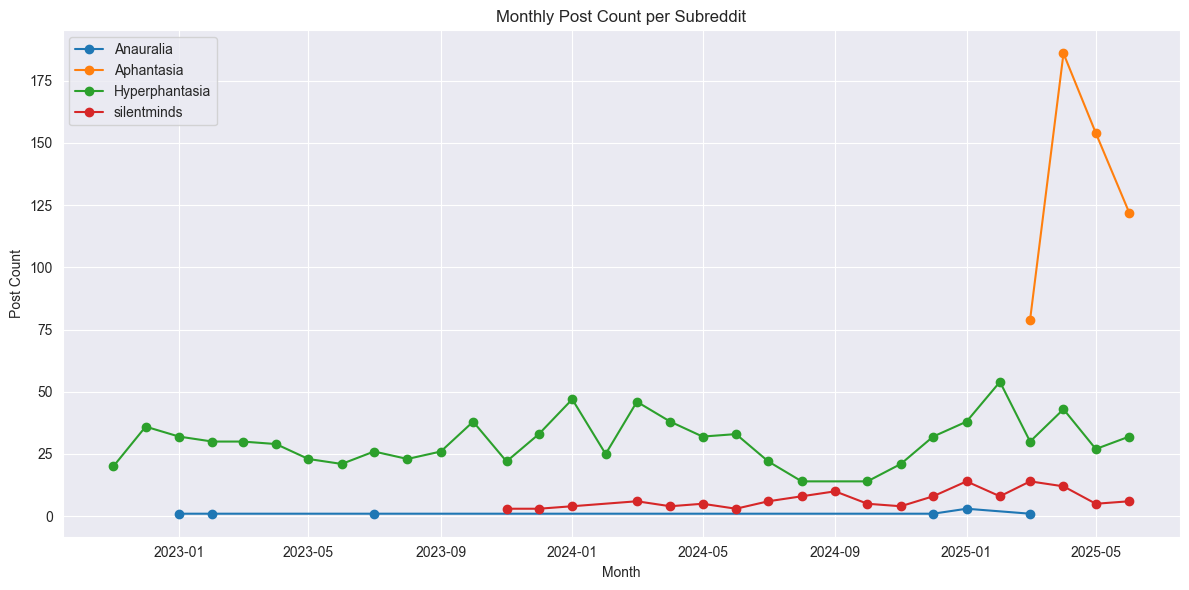

In [124]:
unique_posts = df.drop_duplicates(subset="post_id").copy()

unique_posts["month"] = pd.to_datetime(df["post_timestamp"]).dt.to_period("M")  
monthly_counts = unique_posts.groupby(["subreddit", "month"]).size().reset_index(name="post_count")
monthly_counts["month"] = monthly_counts["month"].dt.to_timestamp()

plt.figure(figsize=(12, 6))
for subreddit in monthly_counts["subreddit"].unique():
    data = monthly_counts[monthly_counts["subreddit"] == subreddit]
    plt.plot(data["month"], data["post_count"], marker="o", label=subreddit)

plt.title("Monthly Post Count per Subreddit")
plt.xlabel("Month")
plt.ylabel("Post Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
post_with_any_links = posts_df[
    posts_df["post_body"].str.contains("http|www", na=False)
]

In [138]:
post_with_any_links[["post_body", "post_id", "post_score", "comment_count", "post_timestamp"]]

post_body  post_id  post_score  \
13    Ignore the study claiming 4% for now. Answer b...  1lmumhw           0   
30    Hey everyone — I’m someone with lifelong aphan...  1li5oq1          79   
42    I’ve been seeing (pun-intended) a lot of confu...  1lfiv72           4   
51    Hey everyone—I'm running a short, anonymous su...  1ldv0vt           9   
52    My sister sent me this Instagram reel from @pe...  1ldt72h          49   
...                                                 ...      ...         ...   
1574   [View Poll](https://www.reddit.com/poll/1f1704u)  1f1704u           2   
1575  Bear in mind, this could also be used on you, ...  1ez76k8           3   
1594  Nice to see the scientist at the end say this ...  1c9de0n           4   
1598  They were able to show that changes in two imp...  1bmg6yr           6   
1608  A new paper talking about those who don’t just...  18agnnt           7   

      comment_count       post_timestamp  
13                8  2025-06-28 20:03:32  
30               57  2025-06-23 03:46:57  
42                4  2025-06-19 19:54:33  
51               10  2025-06-17 19:34:45  
52               14  2025-06-17 18:25:01  
...             ...                  ...  
1574              2  2024-08-25 22:10:18  
1575             27  2024-08-23 09:02:26  
1594              1  2024-04-21 09:59:44  
1598              1  2024-03-24 08:48:09  
1608              2  2023-12-04 09:31:18  

[142 rows x 5 columns]